# 1. Загрузка данных

## 1.1. Распакуем архив

In [205]:
#!unzip data_input4.zip

## 1.2. Произведем предобработку данных

In [206]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

In [207]:
root_folder = "data_input4"
all_files = {}
for fld in next(os.walk(root_folder))[1]:
    path = os.path.join(root_folder, fld)
    all_files[fld] = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

In [208]:
measurements = []
classifications = []

count_healhy = 0
count_sick = 0

for sample in list(all_files):
    for txt in all_files[sample]:
        if "DS_Store" not in str(txt):
            df = pd.read_csv(os.path.join(root_folder,sample,txt), sep='\t',skiprows=[0],
                header=None, names=[ 'Wave', 'Intensity'])
        #time_unique = df.Wave.unique()
            if len(df[['Intensity']].to_numpy()) != 994:
                measurements.append(df[['Intensity']].to_numpy())
                if 'healthy' in str(sample):
                    classifications.append([1,0])
                    count_healhy += 1
                if 'sick' in str(sample):
                    classifications.append([0,1])
                    count_sick += 1

print(f'Здоровые ткани: {count_healhy}')
print(f'Больные ткани: {count_sick}')
print(f'Все ткани: {count_healhy + count_sick}')

Здоровые ткани: 432
Больные ткани: 122
Все ткани: 554


Загрузим дополнительные данные

In [209]:
add_data = "image_tumor_patient20022019_633nm_obj20_power100_1sec_сenter2900.txt"

add_data = pd.read_csv(add_data, sep='\t',skiprows=[0], header=None)

for i in range(468):
    measurements.append(add_data.loc[i : i + 1014][3].to_numpy().reshape(-1, 1))
    classifications.append([0, 1])
    count_sick += 1

print(f'Здоровые ткани: {count_healhy}')
print(f'Больные ткани: {count_sick}')
print(f'Все ткани: {count_healhy + count_sick}')

Здоровые ткани: 432
Больные ткани: 590
Все ткани: 1022


# 2. Анализ данных

Подготовим данные

In [210]:
X = np.array(measurements)
y = np.array(classifications)

In [211]:
X.shape

(1022, 1015, 1)

In [212]:
X = X.reshape(1022, 1015)
X.shape

(1022, 1015)

Сделаем чтобы столбцами стали наши длины волны (Raman Shifts)

In [213]:
raman_shifts = pd.read_csv('data_input4/01_healthy/cortex_patient180219_633nm_obj50_power100_1sec_acc40_сenter2900_place7_20200813_1.txt', sep="\t", header=None)
raman_shifts.drop(columns=[2], inplace = True)
raman_shifts.columns = ["Raman Shifts", "Интенсивность"]
raman_shifts.drop(raman_shifts.head(1).index, inplace=True)
raman_shifts["Raman Shifts"] = pd.to_numeric(raman_shifts["Raman Shifts"], errors='coerce').astype(np.int64)

<Axes: xlabel='Raman Shifts'>

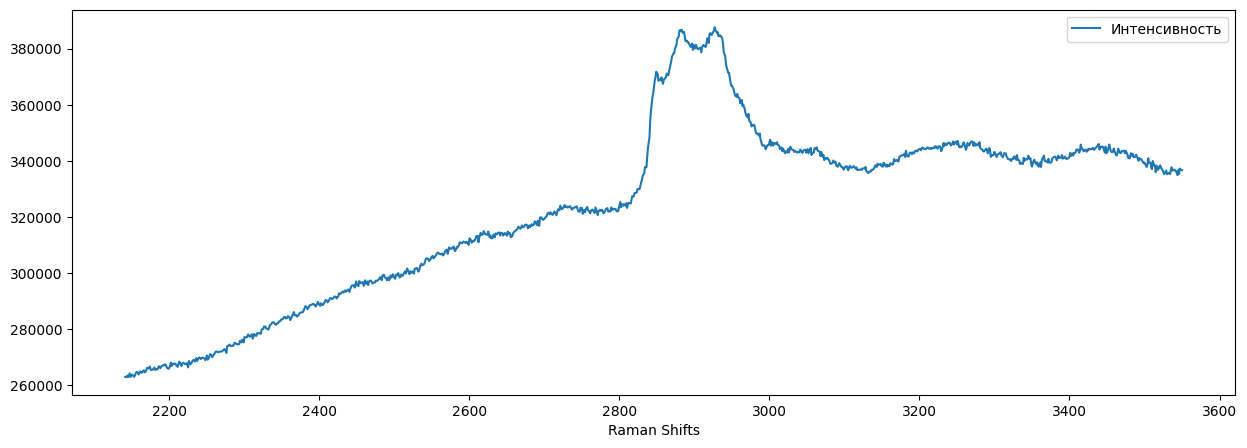

In [214]:
raman_shifts.plot(x = 'Raman Shifts', y = 'Интенсивность', figsize=(15, 5))

In [215]:
raman_shifts = pd.read_csv('data_input4/02_sick/image_tumor_patient20022019_633nm_obj20_power100_1sec_сenter2900_step4um_place1_20200929_1_18.txt', sep="\t", header=None)
raman_shifts.drop(columns=[2], inplace = True)
raman_shifts.columns = ["Raman Shifts", "Интенсивность"]
raman_shifts.drop(raman_shifts.head(1).index, inplace=True)
raman_shifts["Raman Shifts"] = pd.to_numeric(raman_shifts["Raman Shifts"], errors='coerce').astype(np.int64)

<Axes: xlabel='Raman Shifts'>

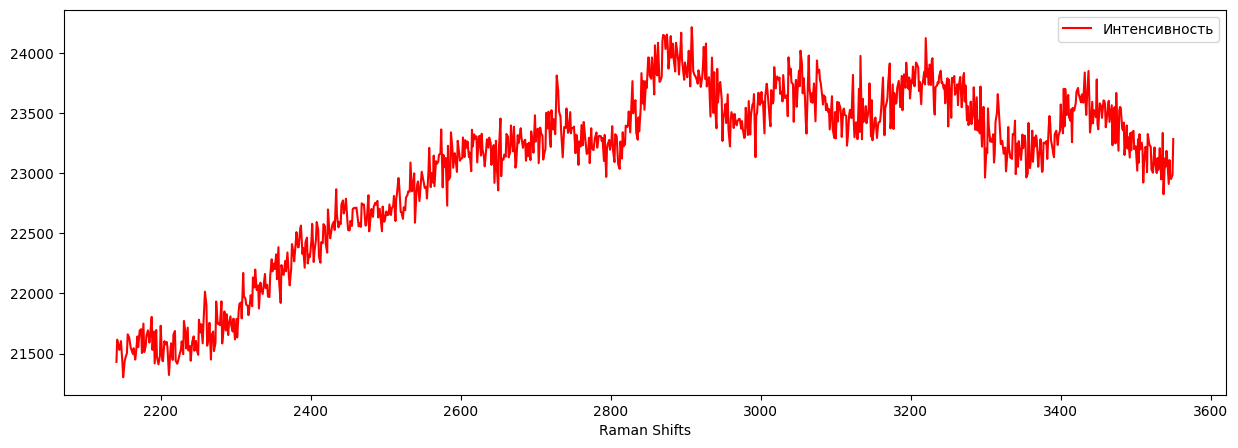

In [216]:
raman_shifts.plot(x = 'Raman Shifts', y = 'Интенсивность', figsize=(15, 5), color = 'red')

In [217]:
raman_shifts["Raman Shifts"].value_counts()

Raman Shifts
3550    1
2641    1
2660    1
2658    1
2657    1
       ..
3111    1
3110    1
3108    1
3107    1
2141    1
Name: count, Length: 1015, dtype: int64

In [218]:
RS = np.array(raman_shifts["Raman Shifts"])
RS

array([3550, 3549, 3547, ..., 2144, 2142, 2141], dtype=int64)

Все в единичном экземпляре, отлично

In [219]:
df = pd.DataFrame(data = X)
df.columns = RS
df = df[RS[::-1]]
target = pd.DataFrame(data = y)
df['target'] = target[1]
df

,2141,2142,2144,2145,2147,2149,2150,2152,2153,2155,...,3540,3541,3542,3544,3545,3546,3547,3549,3550,target
0,559384.687500,560870.375000,560753.125000,562003.375000,562715.687500,560453.625000,559112.875000,559917.562500,560978.625000,561137.687500,...,604160.375000,604214.250000,603745.000000,600736.750000,605210.500000,602977.187500,604778.375000,602853.562500,606627.187500,0
1,15238.749023,15260.290039,15221.147461,15314.583984,15187.541992,15260.236328,15332.966797,15175.439453,15195.393555,15354.565430,...,17407.455078,17476.294922,17374.191406,17500.052734,17273.693359,17544.191406,17486.822266,17445.726563,17588.357422,0
2,32456.476563,32444.185547,32329.664063,32504.253906,32662.951172,32270.251953,32321.837891,32186.328125,32133.931641,32180.714844,...,17615.525391,17692.552734,17720.759766,17689.935547,17785.349609,17679.162109,17670.712891,17823.232422,17670.410156,0
3,24298.855469,24479.248047,24512.789063,24329.062500,24344.998047,24298.597656,24026.726563,24156.138672,24120.845703,24219.943359,...,14811.852539,14819.089844,15086.868164,14864.106445,14985.389648,14868.419922,14816.589844,14970.537109,14817.713867,0
4,299842.875000,300626.875000,299604.843750,300617.593750,301127.500000,300457.968750,300844.906250,300483.593750,299800.500000,301014.718750,...,359393.468750,358979.875000,359775.093750,357985.156250,358857.781250,358109.562500,358465.125000,356567.218750,358735.187500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,22666.765625,22525.132813,...,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,30546.441406,30399.732422,1
1018,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,22666.765625,...,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,30546.441406,1
1019,22623.326172,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,22451.833984,...,30257.056641,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,30348.437500,1
1020,22792.033203,22623.326172,22372.001953,22480.119141,22311.207031,22580.873047,22512.871094,22543.992188,22589.820313,22507.066406,...,30718.039063,30257.056641,30493.115234,30500.468750,30293.595703,30520.667969,30515.199219,30370.468750,30157.855469,1


In [220]:
health = df[df['target'] == 0]
health = health.drop(['target'], axis=1)

sick = df[df['target'] == 1]
sick = sick.drop(['target'], axis=1)

In [221]:
H = pd.DataFrame(health.mean())
H['median'] = health.median()
H['percentile_10'] = health.quantile(.10)
H['percentile_90'] = health.quantile(.90)

S = pd.DataFrame(sick.mean())
S['median'] = sick.median()
S['percentile_10'] = sick.quantile(.10)
S['percentile_90'] = sick.quantile(.90)

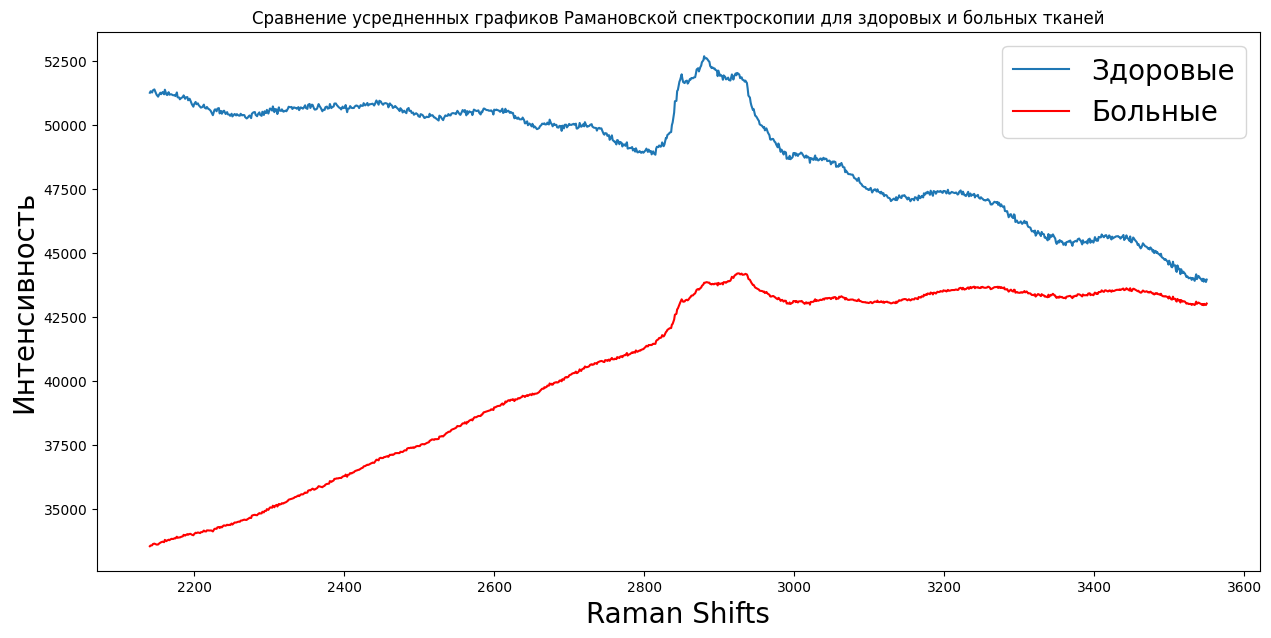

In [222]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

plt.title('Сравнение усредненных графиков Рамановской спектроскопии для здоровых и больных тканей')

plt.plot(H.index, H[0], label='Здоровые')
plt.plot(S.index, S[0], label='Больные', color = 'red')

plt.legend(prop={'size': 20})

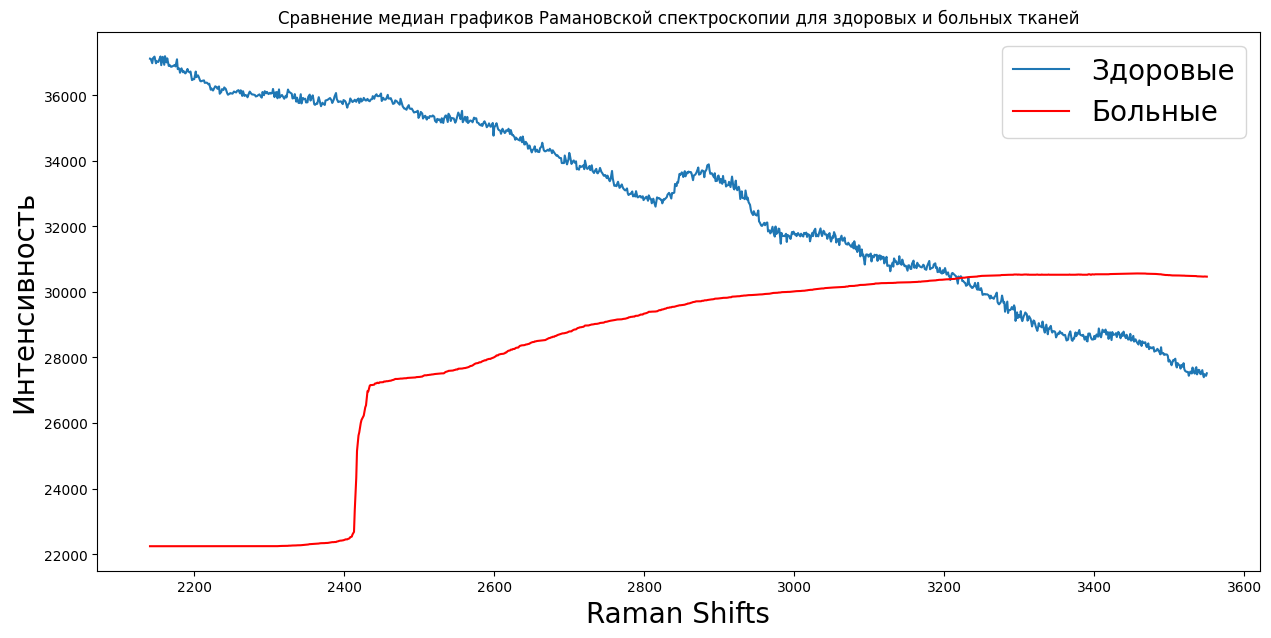

In [223]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

plt.title('Сравнение медиан графиков Рамановской спектроскопии для здоровых и больных тканей')

plt.plot(H.index, H['median'], label='Здоровые')
plt.plot(S.index, S['median'], label='Больные', color = 'red')

plt.legend(prop={'size': 20})

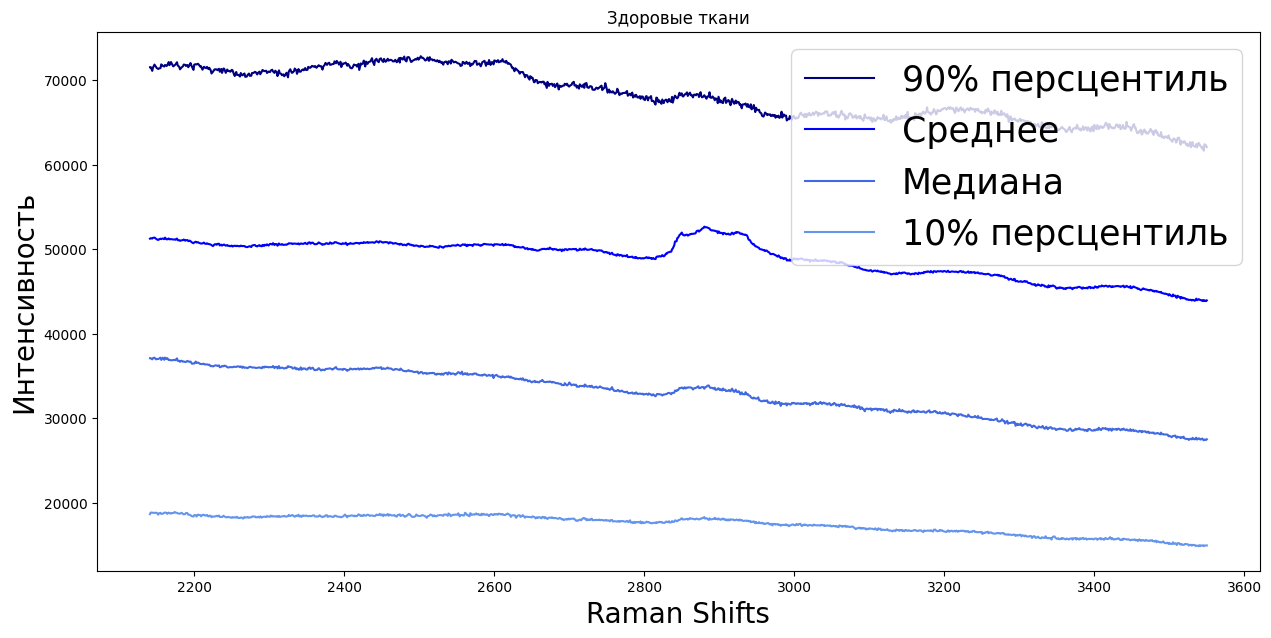

In [224]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

plt.title('Здоровые ткани')

plt.plot(H.index, H['percentile_90'], label='90% персцентиль', color = 'navy')
plt.plot(H.index, H[0], label='Среднее', color = 'blue')
plt.plot(H.index, H['median'], label='Медиана', color = 'royalblue')
plt.plot(H.index, H['percentile_10'], label='10% персцентиль', color = 'cornflowerblue')

plt.legend(prop={'size': 25})

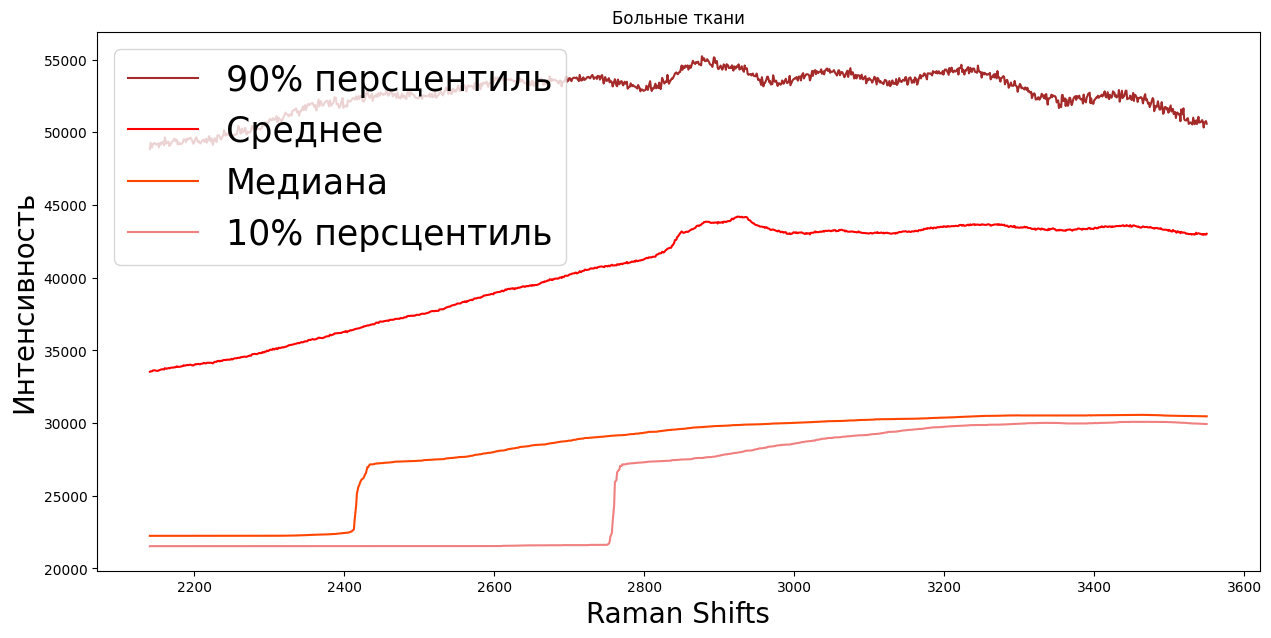

In [225]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

plt.title('Больные ткани')

plt.plot(S.index, S['percentile_90'], label='90% персцентиль', color = 'brown')
plt.plot(S.index, S[0], label='Среднее', color = 'red')
plt.plot(S.index, S['median'], label='Медиана', color = 'orangered')
plt.plot(S.index, S['percentile_10'], label='10% персцентиль', color = 'lightcoral')

plt.legend(prop={'size': 25})

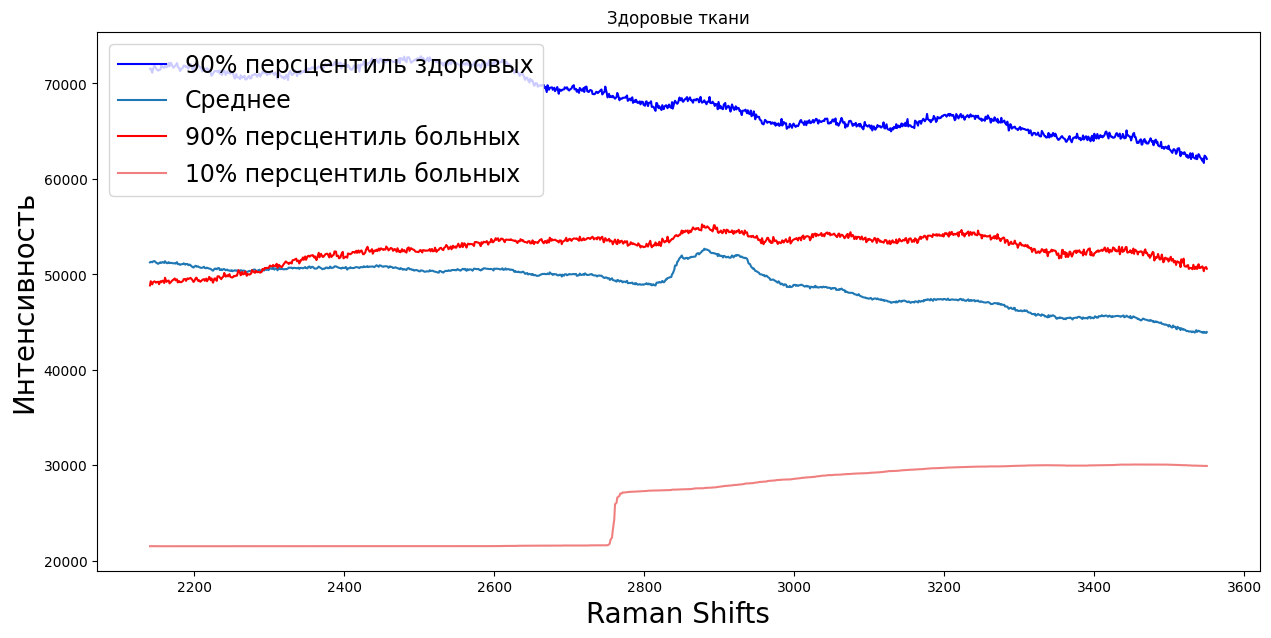

In [226]:
plt.figure(figsize=(15, 7))

plt.ylabel("Интенсивность", fontsize=20)
plt.xlabel("Raman Shifts", fontsize=20)

plt.title('Здоровые ткани')

plt.plot(H.index, H['percentile_90'], label='90% персцентиль здоровых', color = 'blue')
plt.plot(H.index, H[0], label='Среднее')
#plt.plot(H.index, H['median'], label='Медиана')
#plt.plot(H.index, H['percentile_10'], label='10% персцентиль здоровых', color = 'cornflowerblue')

plt.plot(S.index, S['percentile_90'], label='90% персцентиль больных', color = 'red')
#plt.plot(S.index, S[0], label='Среднее')
#plt.plot(S.index, S['median'], label='Медиана')
plt.plot(S.index, S['percentile_10'], label='10% персцентиль больных', color = 'lightcoral')

plt.legend(prop={'size': 17})

In [227]:
df['target'].value_counts()

target
1    590
0    432
Name: count, dtype: int64

# 3. Classic ML

In [228]:
X = df.drop(['target'], axis=1)
y = df['target']

In [229]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [230]:
print(f'Total amount of train measurements: {X_train.shape}')
print(f'Total amount of train labels: {y_train.shape}')
print(f'Total amount of test measurements: {X_test.shape}')
print(f'Total amount of test labels: {y_test.shape}')

Total amount of train measurements: (817, 1015)
Total amount of train labels: (817,)
Total amount of test measurements: (205, 1015)
Total amount of test labels: (205,)


## 3.1 Logistic regression

In [231]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [232]:
LogReg = LogisticRegression(solver='lbfgs', max_iter=100000)
LogReg.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [233]:
y_pred_lr = LogReg.predict(X_test)

print(f'Logistic Regression F1 Score {f1_score(y_test, y_pred_lr)}')
print(f'Logistic Regression Accuracy {accuracy_score(y_test, y_pred_lr)}')

Logistic Regression F1 Score 0.9173553719008264
Logistic Regression Accuracy 0.9024390243902439


In [234]:
y_test.value_counts()

target
1    124
0     81
Name: count, dtype: int64

In [235]:
from sklearn.metrics import confusion_matrix 

cm_lr = pd.DataFrame(confusion_matrix(y_test, y_pred_lr))
cm_lr

,0,1
0,74,7
1,13,111


In [236]:
sensitivity = cm_lr[0][0] / (cm_lr[0][0] + cm_lr[1][0])
specificity = cm_lr[1][1] / (cm_lr[0][1] + cm_lr[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9135802469135802
Доля верно обнаруженных больных :  0.8951612903225806


In [237]:
LR_metric = [accuracy_score(y_test, y_pred_lr), f1_score(y_test, y_pred_lr), specificity, sensitivity]
LR_metric

[0.9024390243902439,
 0.9173553719008264,
 0.8951612903225806,
 0.9135802469135802]

## 3.2 Support vector machine (SVM)

In [238]:
from sklearn.svm import SVC

SVM_rbf = SVC(kernel='rbf')
SVM_rbf.fit(X_train, y_train)

SVC()

In [239]:
y_pred_svm_rbf = SVM_rbf.predict(X_test)

print(f'Rbf SVM F1 Score {f1_score(y_test, y_pred_svm_rbf)}')
print(f'Rbf SVM Accuracy {accuracy_score(y_test, y_pred_svm_rbf)}')

Rbf SVM F1 Score 0.8787878787878788
Rbf SVM Accuracy 0.8439024390243902


Попробуем линейный SVM

In [240]:
SVM_lnr = SVC(kernel='linear')
SVM_lnr.fit(X_train, y_train)

SVC(kernel='linear')

In [241]:
y_pred_svm_lnr = SVM_lnr.predict(X_test)

print(f'Linear SVM F1 Score {f1_score(y_test, y_pred_svm_lnr)}')
print(f'Linear SVM Accuracy {accuracy_score(y_test, y_pred_svm_lnr)}')

Linear SVM F1 Score 0.921161825726141
Linear SVM Accuracy 0.9073170731707317


In [242]:
cm_svm_lnr = pd.DataFrame(confusion_matrix(y_test, y_pred_svm_lnr))
cm_svm_lnr

,0,1
0,75,6
1,13,111


In [243]:
sensitivity = cm_svm_lnr[0][0] / (cm_svm_lnr[0][0] + cm_svm_lnr[1][0])
specificity = cm_svm_lnr[1][1] / (cm_svm_lnr[0][1] + cm_svm_lnr[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9259259259259259
Доля верно обнаруженных больных :  0.8951612903225806


In [244]:
SVM_metric = [accuracy_score(y_test, y_pred_svm_lnr), f1_score(y_test, y_pred_svm_lnr), specificity, sensitivity]
SVM_metric

[0.9073170731707317, 0.921161825726141, 0.8951612903225806, 0.9259259259259259]

## 3.3 Random forest

In [245]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [246]:
y_pred_rf = RF.predict(X_test)

print(f'Random forest F1 Score {f1_score(y_test, y_pred_rf)}')
print(f'Random forest Accuracy {accuracy_score(y_test, y_pred_rf)}')

Random forest F1 Score 0.9306122448979591
Random forest Accuracy 0.9170731707317074


In [247]:
cm_rf = pd.DataFrame(confusion_matrix(y_test, y_pred_rf))
cm_rf

,0,1
0,74,7
1,10,114


In [248]:
sensitivity = cm_rf[0][0] / (cm_rf[0][0] + cm_rf[1][0])
specificity = cm_rf[1][1] / (cm_rf[0][1] + cm_rf[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9135802469135802
Доля верно обнаруженных больных :  0.9193548387096774


In [249]:
RF_metric = [accuracy_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf), specificity, sensitivity]
RF_metric

[0.9170731707317074,
 0.9306122448979591,
 0.9193548387096774,
 0.9135802469135802]

## 3.4 Catboost

In [250]:
from catboost import CatBoostClassifier

CatBoost = CatBoostClassifier(verbose=False)
CatBoost.fit(X_train, y_train)

In [251]:
y_pred_cb = CatBoost.predict(X_test)

print(f'CatBoost F1 Score {f1_score(y_test, y_pred_cb)}')
print(f'CatBoost Accuracy {accuracy_score(y_test, y_pred_cb)}')

CatBoost F1 Score 0.9377593360995851
CatBoost Accuracy 0.926829268292683


In [252]:
cm_cb = pd.DataFrame(confusion_matrix(y_test, y_pred_cb))
cm_cb

,0,1
0,77,4
1,11,113


In [253]:
sensitivity = cm_cb[0][0] / (cm_cb[0][0] + cm_cb[1][0])
specificity = cm_cb[1][1] / (cm_cb[0][1] + cm_cb[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9506172839506173
Доля верно обнаруженных больных :  0.9112903225806451


In [254]:
CB_metric = [accuracy_score(y_test, y_pred_cb), f1_score(y_test, y_pred_cb), specificity, sensitivity]
CB_metric

[0.926829268292683, 0.9377593360995851, 0.9112903225806451, 0.9506172839506173]

## 3.5 Ансамбль моделей

Дадим CatBoost и RF вес 2, как лучшим моделям

In [255]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 0.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,6,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,0,0
717,1,6,1
925,1,6,1
559,1,6,1


In [256]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9260700389105059
Ensemble Accuracy 0.9073170731707317


In [257]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,67,14
1,5,119


In [258]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.8271604938271605
Доля верно обнаруженных больных :  0.9596774193548387


In [259]:
ENS_1_metric = [acc, f1, specificity, sensitivity]
ENS_1_metric

[0.9073170731707317,
 0.9260700389105059,
 0.9596774193548387,
 0.8271604938271605]

выберем порог < 1.5

In [260]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 1.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,6,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,0,0
717,1,6,1
925,1,6,1
559,1,6,1


In [261]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9365079365079365
Ensemble Accuracy 0.9219512195121952


In [262]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,71,10
1,6,118


In [263]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.8765432098765432
Доля верно обнаруженных больных :  0.9516129032258065


In [264]:
ENS_2_metric = [acc, f1, specificity, sensitivity]
ENS_2_metric

[0.9219512195121952,
 0.9365079365079365,
 0.9516129032258065,
 0.8765432098765432]

выберем порог < 2.5

In [265]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 2.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,6,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,0,0
717,1,6,1
925,1,6,1
559,1,6,1


In [266]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9421487603305785
Ensemble Accuracy 0.9317073170731708


In [267]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,77,4
1,10,114


In [268]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9506172839506173
Доля верно обнаруженных больных :  0.9193548387096774


In [269]:
ENS_3_metric = [acc, f1, specificity, sensitivity]
ENS_3_metric

[0.9317073170731708,
 0.9421487603305785,
 0.9193548387096774,
 0.9506172839506173]

Выберем порог < 3.5

In [270]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 3.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,6,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,0,0
717,1,6,1
925,1,6,1
559,1,6,1


In [271]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9377593360995851
Ensemble Accuracy 0.926829268292683


In [272]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,77,4
1,11,113


In [273]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9506172839506173
Доля верно обнаруженных больных :  0.9112903225806451


In [274]:
ENS_4_metric = [acc, f1, specificity, sensitivity]
ENS_4_metric

[0.926829268292683, 0.9377593360995851, 0.9112903225806451, 0.9506172839506173]

выберем порог < 4.5

In [275]:
ensemble = pd.DataFrame(y_test)

ensemble['sum'] = y_pred_lr * 1 + y_pred_svm_lnr * 1 + y_pred_rf * 2 + y_pred_cb * 2
ensemble['target_pred'] = ensemble['sum'].apply ( lambda x: 0 if x < 4.5 else 1)

ensemble

,target,sum,target_pred
992,1,6,1
478,1,6,1
689,1,6,1
31,0,0,0
617,1,6,1
...,...,...,...
451,1,0,0
717,1,6,1
925,1,6,1
559,1,6,1


In [276]:
f1 = f1_score(ensemble['target'], ensemble['target_pred'])
acc = accuracy_score(ensemble['target'], ensemble['target_pred'])

print(f'Ensemble F1 Score {f1}')
print(f'Ensemble Accuracy {acc}')

Ensemble F1 Score 0.9184549356223176
Ensemble Accuracy 0.9073170731707317


In [277]:
cm_ens = pd.DataFrame(confusion_matrix(ensemble['target'], ensemble['target_pred']))
cm_ens

,0,1
0,79,2
1,17,107


In [278]:
sensitivity = cm_ens[0][0] / (cm_ens[0][0] + cm_ens[1][0])
specificity = cm_ens[1][1] / (cm_ens[0][1] + cm_ens[1][1])

print('Доля верно обнаруженных здоровых : ', sensitivity )
print('Доля верно обнаруженных больных : ', specificity)

Доля верно обнаруженных здоровых :  0.9753086419753086
Доля верно обнаруженных больных :  0.8629032258064516


In [279]:
ENS_5_metric = [acc, f1, specificity, sensitivity]
ENS_5_metric

[0.9073170731707317,
 0.9184549356223176,
 0.8629032258064516,
 0.9753086419753086]

## 3.6 Результаты

In [280]:
res_all = pd.DataFrame()

res_all['LR'] = LR_metric
res_all['SVM'] = SVM_metric
res_all['RF'] = RF_metric
res_all['CB'] = CB_metric
res_all['ENS_1'] = ENS_1_metric
res_all['ENS_2'] = ENS_2_metric
res_all['ENS_3'] = ENS_3_metric
res_all['ENS_4'] = ENS_4_metric
res_all['ENS_5'] = ENS_5_metric

res_all.index = ['Точность', 'F1 мера', 'Доля верно обнаруженных больных', 'Доля верно обнаруженных здоровых']
res_all = res_all.round(3)
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975


In [281]:
res_classic_ml = res_all

In [282]:
res_classic_ml.to_csv('results/results_classic_ml.csv')  

# 4. Кластеризация без учителя

## 4.1. TSNE

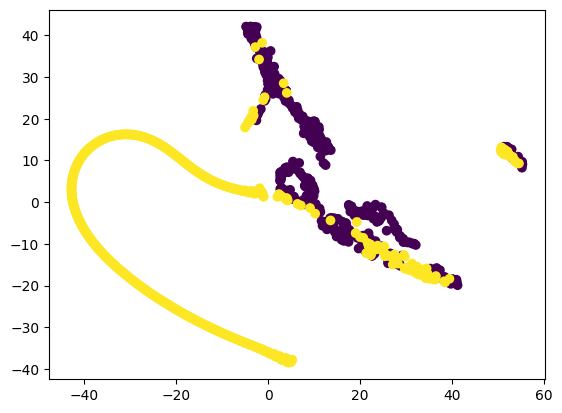

In [283]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model = TSNE(learning_rate=100)

transformed = model.fit_transform(X)

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis, c=y)
plt.show()

## 4.2. K-means

In [284]:
from sklearn.cluster import KMeans

acc_sc = pd.Series()
f1_scr = pd.Series()
sensit = pd.Series()
specif = pd.Series()

iter = 50

for i in range (2, iter):
  model = KMeans(n_clusters=i)
  model.fit(X)

  all_predictions = model.predict(X)
  A = pd.DataFrame(all_predictions)
  A[1] = y

  K1 = A[A[1] == 1]
  s1 = set(K1[0])

  K0 = A[A[1] == 0]
  s0 = set(K0[0])

  A['pred'] = A[0].apply(lambda x: 0 if ((x in s1) == False) else
                                   1 if ((x in s0) == False) else
                                   0 if (A.groupby([1, 0]).value_counts()[0, x] > A.groupby([1, 0]).value_counts()[1, x]) else 1)
  
  acc = accuracy_score(A[1], A['pred'])
  f1 = f1_score(A[1], A['pred'])

  cm = pd.DataFrame(confusion_matrix(A[1], A['pred']))
  sensitivity = cm[0][0] / (cm[0][0] + cm[1][0])
  specificity = cm[1][1] / (cm[0][1] + cm[1][1])

  acc_sc[str(i)] = round(acc, 3)
  f1_scr[str(i)] = round(f1, 3)
  sensit[str(i)] = round(sensitivity, 3)
  specif[str(i)] = round(specificity, 3)

c:\Users\DIMEDROL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DIMEDROL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DIMEDROL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DIMEDROL\AppData\Local\Programs\Python\Python311\Lib\site-packages\

In [285]:
Res = pd.DataFrame()
Res['Точность'] = acc_sc
Res['F1 мера'] = f1_scr
Res['Доля верно обнаруженных здоровых'] = sensit
Res['Доля верно обнаруженных больных'] = specif

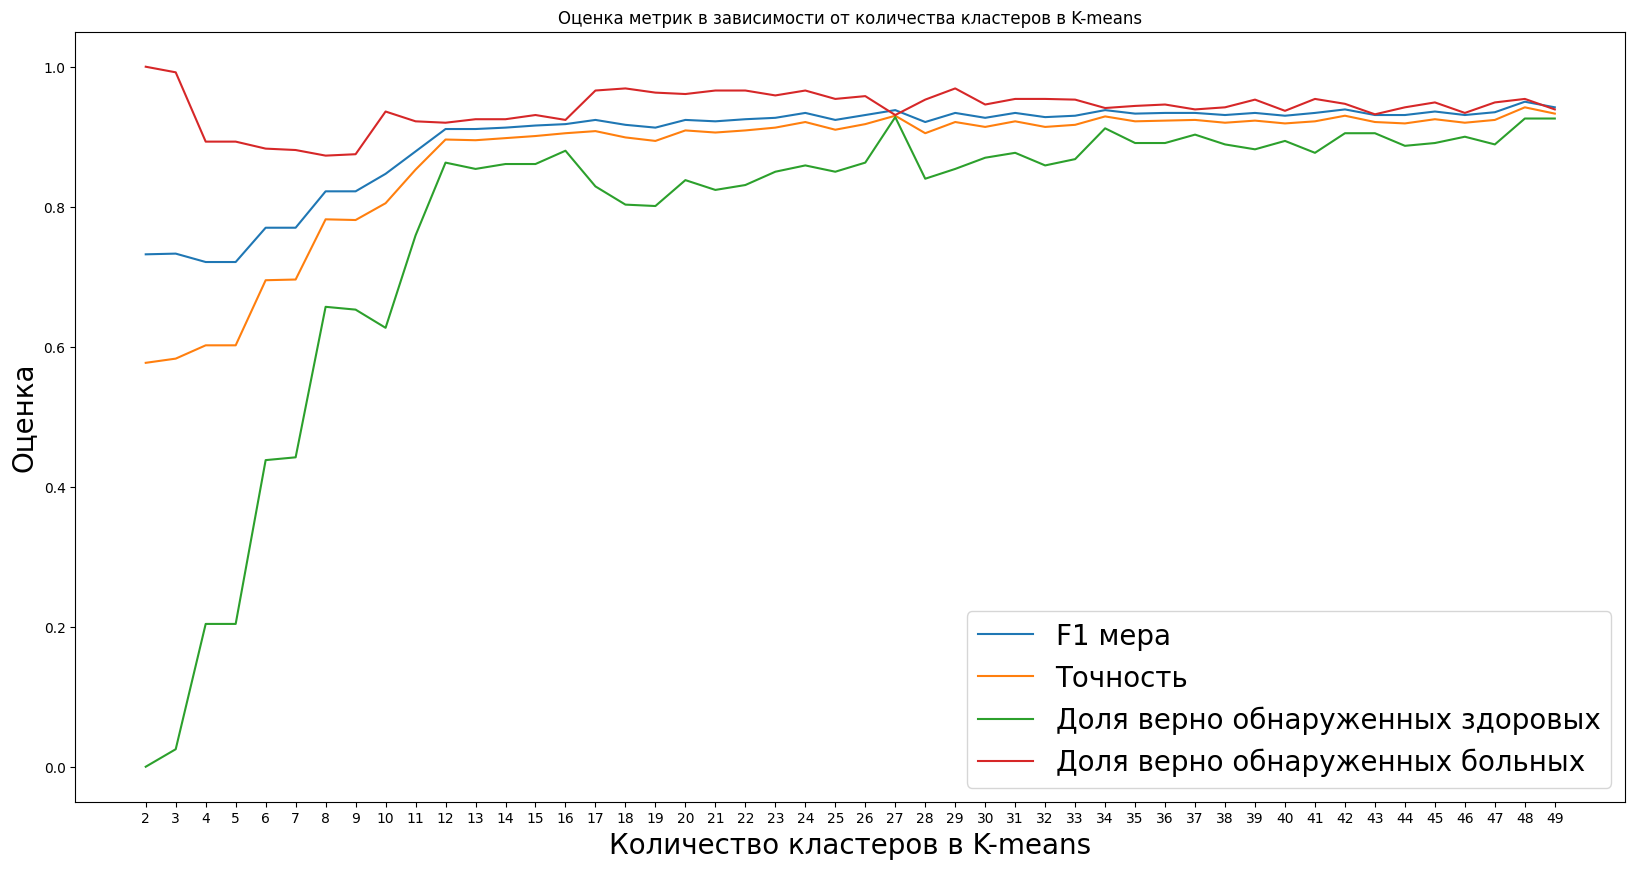

In [286]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка", fontsize=20)
plt.xlabel("Количество кластеров в K-means", fontsize=20)

plt.title('Оценка метрик в зависимости от количества кластеров в K-means')

plt.plot(Res.index, Res['F1 мера'], label='F1 мера')
plt.plot(Res.index, Res['Точность'], label='Точность')
plt.plot(Res.index, Res['Доля верно обнаруженных здоровых'], label='Доля верно обнаруженных здоровых')
plt.plot(Res.index, Res['Доля верно обнаруженных больных'], label='Доля верно обнаруженных больных')

plt.legend(prop={'size': 20})

In [287]:
Res.sort_values(by='F1 мера', ascending=False)

,Точность,F1 мера,Доля верно обнаруженных здоровых,Доля верно обнаруженных больных
48,0.942,0.950,0.926,0.954
49,0.933,0.942,0.926,0.939
42,0.930,0.939,0.905,0.947
34,0.929,0.938,0.912,0.941
27,0.930,0.938,0.928,0.931
45,0.925,0.936,0.891,0.949
47,0.924,0.935,0.889,0.949
24,0.921,0.934,0.859,0.966
39,0.923,0.934,0.882,0.953
37,0.924,0.934,0.903,0.939


In [288]:
from sklearn.cluster import KMeans

acc_sc = pd.Series()
f1_scr = pd.Series()
sensit = pd.Series()
specif = pd.Series()

iter = 50

for i in range (15, iter):

  acc = 0
  f1 = 0
  sensitivity = 0
  specificity = 0

  for j in range (10):
    model = KMeans(n_clusters=i)
    model.fit(X)

    all_predictions = model.predict(X)
    A = pd.DataFrame(all_predictions)
    A[1] = y

    K1 = A[A[1] == 1]
    s1 = set(K1[0])

    K0 = A[A[1] == 0]
    s0 = set(K0[0])

    A['pred'] = A[0].apply(lambda x: 0 if ((x in s1) == False) else
                                     1 if ((x in s0) == False) else
                                     0 if (A.groupby([1, 0]).value_counts()[0, x] > A.groupby([1, 0]).value_counts()[1, x]) else 1)
  
    acc += accuracy_score(A[1], A['pred'])
    f1 += f1_score(A[1], A['pred'])

    cm = pd.DataFrame(confusion_matrix(A[1], A['pred']))
    sensitivity += cm[0][0] / (cm[0][0] + cm[1][0])
    specificity += cm[1][1] / (cm[0][1] + cm[1][1])

  acc_sc[str(i)] = round(acc / 10, 3)
  f1_scr[str(i)] = round(f1 / 10, 3)
  sensit[str(i)] = round(sensitivity / 10, 3)
  specif[str(i)] = round(specificity / 10, 3)

c:\Users\DIMEDROL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DIMEDROL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DIMEDROL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DIMEDROL\AppData\Local\Programs\Python\Python311\Lib\site-packages\

In [289]:
Res = pd.DataFrame()
Res['Точность'] = acc_sc
Res['F1 мера'] = f1_scr
Res['Доля верно обнаруженных здоровых'] = sensit
Res['Доля верно обнаруженных больных'] = specif

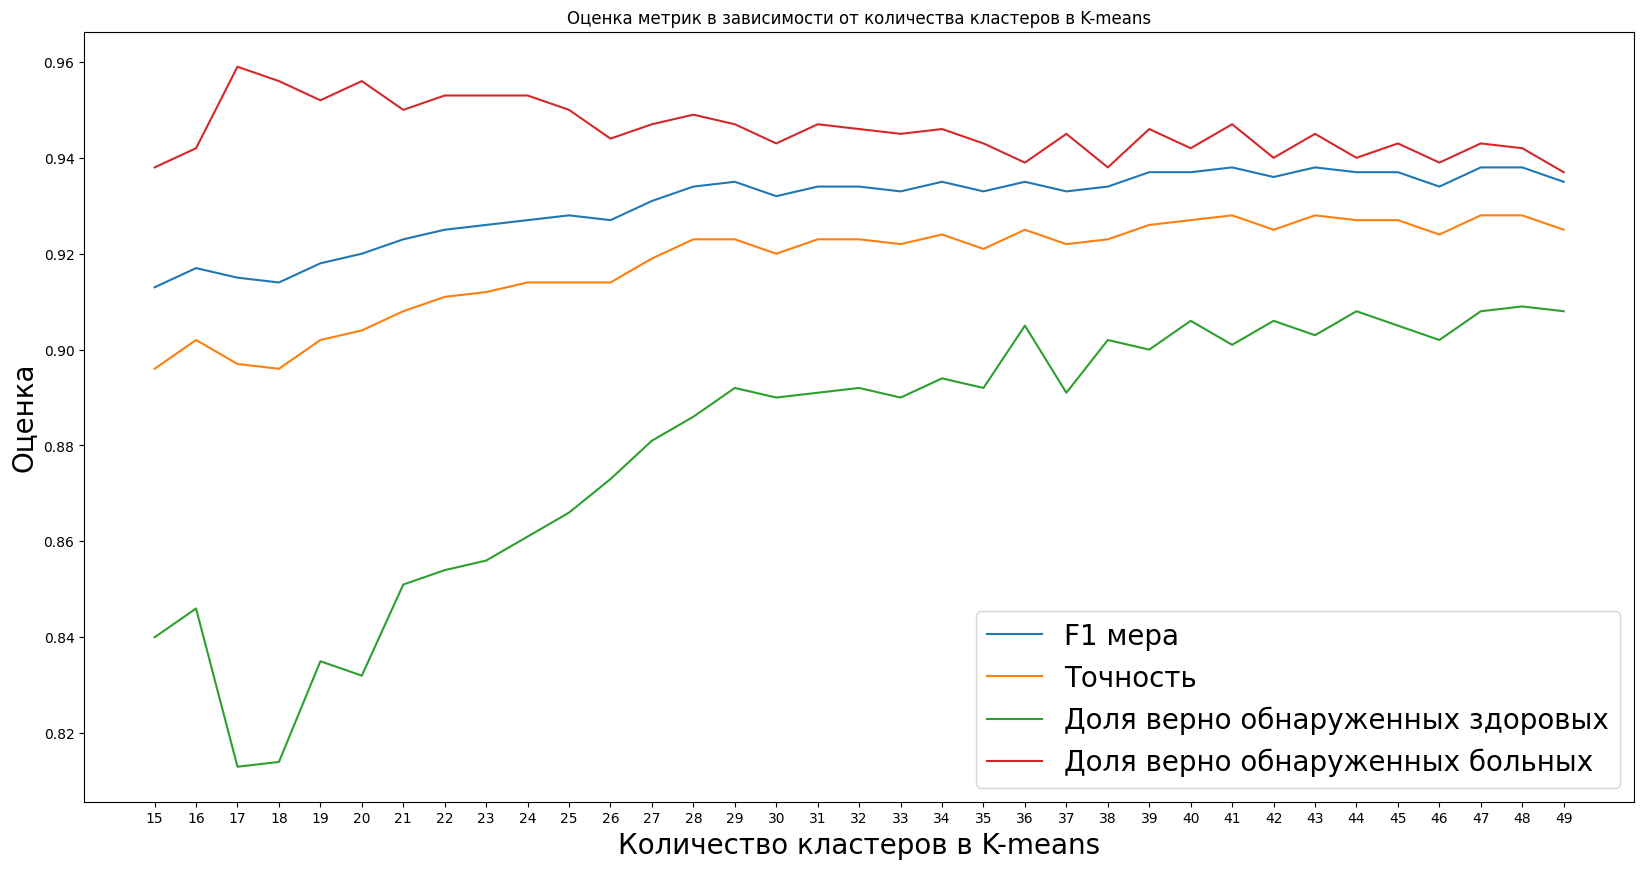

In [290]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка", fontsize=20)
plt.xlabel("Количество кластеров в K-means", fontsize=20)

plt.title('Оценка метрик в зависимости от количества кластеров в K-means')

plt.plot(Res.index, Res['F1 мера'], label='F1 мера')
plt.plot(Res.index, Res['Точность'], label='Точность')
plt.plot(Res.index, Res['Доля верно обнаруженных здоровых'], label='Доля верно обнаруженных здоровых')
plt.plot(Res.index, Res['Доля верно обнаруженных больных'], label='Доля верно обнаруженных больных')

plt.legend(prop={'size': 20})

In [291]:
Res.sort_values(by='F1 мера', ascending=False).head(20)

,Точность,F1 мера,Доля верно обнаруженных здоровых,Доля верно обнаруженных больных
48,0.928,0.938,0.909,0.942
47,0.928,0.938,0.908,0.943
43,0.928,0.938,0.903,0.945
41,0.928,0.938,0.901,0.947
45,0.927,0.937,0.905,0.943
44,0.927,0.937,0.908,0.940
40,0.927,0.937,0.906,0.942
39,0.926,0.937,0.900,0.946
42,0.925,0.936,0.906,0.940
49,0.925,0.935,0.908,0.937


Выводы

In [292]:
Best_3 = Res.sort_values(by='F1 мера', ascending=False).head(3)
Best_3 = Best_3.T
Best_3

,48,47,43
Точность,0.928,0.928,0.928
F1 мера,0.938,0.938,0.938
Доля верно обнаруженных здоровых,0.909,0.908,0.903
Доля верно обнаруженных больных,0.942,0.943,0.945


In [293]:
Best_3.columns = ['K_means_1', 'K_means_2', 'K_means_3']
res_all['K_means_1'] = Best_3['K_means_1']
res_all['K_means_2'] = Best_3['K_means_2']
res_all['K_means_3'] = Best_3['K_means_3']

res_all = res_all.round(3)
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907,0.928,0.928,0.928
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918,0.938,0.938,0.938
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863,0.942,0.943,0.945
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975,0.909,0.908,0.903


In [294]:
res_K_means = res_all.drop(columns= ['LR', 'SVM','RF','CB', 'ENS_1', 'ENS_2', 'ENS_3', 'ENS_4', 'ENS_5'])

In [295]:
res_K_means

,K_means_1,K_means_2,K_means_3
Точность,0.928,0.928,0.928
F1 мера,0.938,0.938,0.938
Доля верно обнаруженных больных,0.942,0.943,0.945
Доля верно обнаруженных здоровых,0.909,0.908,0.903


In [296]:
res_K_means.to_csv('results/result_K_means.csv') 

# 5. Отбор признаков

## 5.1. Взаимная информация

Отберем 20 самых информативных Raman Shift

<Axes: xlabel='Raman Shift'>

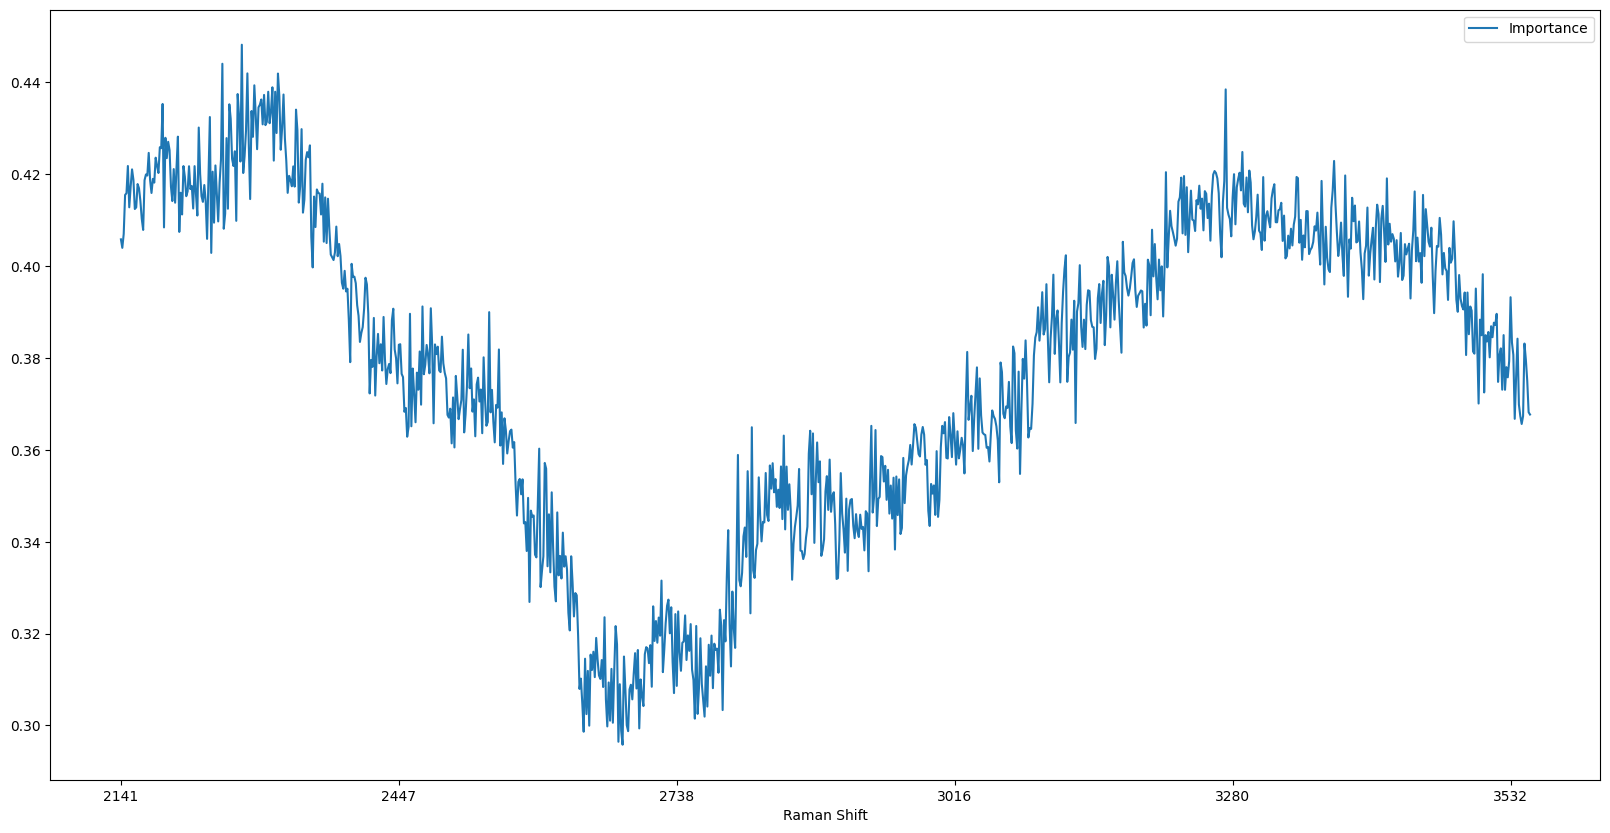

In [297]:
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_classif(X, y)
# Где data - ваш датасет; X, y – входные и выходные данные соответственно
feature_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])
feature_importances = pd.DataFrame(feature_importances)
feature_importances.columns = ['Importance']
feature_importances['Raman Shift'] = feature_importances.index
feature_importances.plot(x = 'Raman Shift', y = 'Importance', figsize=(20, 10))

In [298]:
feature_importances = pd.DataFrame(feature_importances)
feature_importances = feature_importances.sort_values(by=['Importance'], ascending=False)
feature_importances.reset_index(inplace = True)
feature_importances.drop('index', axis=1, inplace = True)
feature_importances

,Importance,Raman Shift
0,0.448217,2276
1,0.444072,2254
2,0.441974,2282
3,0.441940,2316
4,0.439378,2290
...,...,...
1010,0.298828,2681
1011,0.298763,2689
1012,0.298634,2642
1013,0.296452,2678


Напишем функцию для отбора n лучших признаков

In [299]:
def df_best_n_features(n):

  n_features = feature_importances.head(n)
  best_n_ftr_list = list(n_features['Raman Shift'])

  df_t = df.T
  df_best_n_features = df_t.loc[best_n_ftr_list]
  df_best_n_features = df_best_n_features.T
  df_best_n_features['target'] = df.target

  return(df_best_n_features)

Оставим лучшие 50 признаков

In [300]:
df_best_50_features = df_best_n_features(50)
df_best_50_features

,2276,2254,2282,2316,2290,2310,3273,2313,2305,2271,...,2284,2351,2185,2186,2293,2319,2195,2268,3289,target
0,561302.500000,561755.000000,564330.250000,569547.250000,564855.437500,568009.125000,618386.500000,568908.500000,567538.375000,561950.437500,...,563740.437500,572052.875000,562040.062500,563812.500000,563938.875000,566349.375000,561606.500000,560244.250000,613102.125000,0
1,15557.718750,15460.772461,15362.963867,15831.852539,15535.037109,15615.184570,17980.449219,15863.120117,15673.658203,15418.387695,...,15517.351563,15939.139648,15405.010742,15302.861328,15580.728516,15881.136719,15433.086914,15372.904297,17768.564453,0
2,30337.593750,30585.800781,30741.671875,29856.480469,30144.746094,30282.224609,20352.205078,30439.154297,30224.330078,30258.583984,...,30559.958984,29908.177734,32126.484375,31748.800781,30306.068359,30118.593750,31530.958984,30735.427734,19911.156250,0
3,23190.402344,23482.357422,23307.572266,23443.632813,23121.666016,23082.806641,16854.656250,23272.167969,23201.140625,23196.888672,...,23063.441406,23392.738281,24131.044922,24032.771484,23087.763672,23133.355469,23949.480469,23418.089844,16702.003906,0
4,308233.843750,306788.687500,309479.593750,314356.000000,309776.656250,314903.781250,371700.531250,314343.375000,314481.250000,308379.781250,...,309209.718750,318966.906250,302680.125000,303789.906250,310586.843750,314348.750000,304356.218750,307996.843750,368960.187500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,22260.986328,29712.716797,22015.281250,22215.191406,22600.001953,...,22633.355469,22207.082031,22443.265625,22356.267578,22333.017578,22188.679688,22545.599609,22372.314453,29713.128906,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,22210.582031,29519.359375,22305.763672,22454.488281,22568.464844,...,22770.496094,22228.414063,22692.705078,22443.265625,22258.292969,22373.847656,22460.685547,22655.052734,29738.818359,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,22188.423828,29581.453125,22260.986328,22306.289063,22372.314453,...,22337.785156,22030.060547,22476.832031,22692.705078,22309.355469,22315.832031,22464.564453,22558.070313,29773.201172,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,22215.191406,29818.916016,22210.582031,22126.199219,22655.052734,...,22431.828125,22091.179688,22377.328125,22476.832031,22549.919922,22474.501953,22470.287109,22616.294922,29713.501953,1


In [301]:
X_50 = df_best_50_features.drop(['target'], axis=1)
y_50 = df_best_50_features['target']

X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_50, y_50, test_size=0.2, random_state=42)

In [302]:
RF = RandomForestClassifier()
RF.fit(X_train_50, y_train_50)

y_pred_rf_50 = RF.predict(X_test_50)

print(f'Random forest F1 Score на 50 признаках {f1_score(y_test_50, y_pred_rf_50)}')
print(f'Random forest Accuracy на 50 признаках {accuracy_score(y_test_50, y_pred_rf_50)}')

Random forest F1 Score на 50 признаках 0.9180327868852459
Random forest Accuracy на 50 признаках 0.9024390243902439


Оставим лучшие 20 признаков

In [303]:
df_best_20_features = df_best_n_features(20)
df_best_20_features

,2276,2254,2282,2316,2290,2310,3273,2313,2305,2271,...,2301,2317,2297,2188,2262,2296,2294,2336,2308,target
0,561302.500000,561755.000000,564330.250000,569547.250000,564855.437500,568009.125000,618386.500000,568908.500000,567538.375000,561950.437500,...,567759.812500,569294.562500,567815.750000,562224.812500,561578.687500,565794.875000,566297.375000,572479.375000,567496.437500,0
1,15557.718750,15460.772461,15362.963867,15831.852539,15535.037109,15615.184570,17980.449219,15863.120117,15673.658203,15418.387695,...,15784.496094,16016.805664,15758.320313,15395.332031,15405.868164,15701.825195,15578.202148,15757.977539,15676.825195,0
2,30337.593750,30585.800781,30741.671875,29856.480469,30144.746094,30282.224609,20352.205078,30439.154297,30224.330078,30258.583984,...,30125.509766,30193.044922,30406.583984,31876.123047,30475.548828,30189.017578,30248.378906,29865.947266,30174.263672,0
3,23190.402344,23482.357422,23307.572266,23443.632813,23121.666016,23082.806641,16854.656250,23272.167969,23201.140625,23196.888672,...,23076.603516,23038.597656,23376.064453,23868.478516,23300.998047,23293.023438,23311.578125,23189.117188,23375.654297,0
4,308233.843750,306788.687500,309479.593750,314356.000000,309776.656250,314903.781250,371700.531250,314343.375000,314481.250000,308379.781250,...,312837.593750,315157.250000,312833.406250,302984.062500,307880.125000,311677.906250,310880.000000,317403.250000,313615.875000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,22260.986328,29712.716797,22015.281250,22215.191406,22600.001953,...,22126.199219,22373.847656,22523.562500,22324.660156,22667.013672,22377.355469,22364.574219,22181.687500,22210.582031,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,22210.582031,29519.359375,22305.763672,22454.488281,22568.464844,...,22551.419922,22315.832031,22377.355469,22356.267578,22682.205078,22364.574219,22333.017578,22337.126953,22188.423828,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,22188.423828,29581.453125,22260.986328,22306.289063,22372.314453,...,22523.562500,22474.501953,22364.574219,22443.265625,22564.750000,22333.017578,22258.292969,22095.730469,22215.191406,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,22215.191406,29818.916016,22210.582031,22126.199219,22655.052734,...,22377.355469,22015.281250,22333.017578,22692.705078,22385.714844,22258.292969,22309.355469,22273.779297,22454.488281,1


In [304]:
X_20 = df_best_20_features.drop(['target'], axis=1)
y_20 = df_best_20_features['target']

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.2, random_state=42)

In [305]:
RF.fit(X_train_20, y_train_20)

y_pred_rf_20 = RF.predict(X_test_20)

print(f'Random forest F1 Score на 20 признаках {f1_score(y_test_20, y_pred_rf_20)}')
print(f'Random forest Accuracy на 20 признаках {accuracy_score(y_test_20, y_pred_rf_20)}')

Random forest F1 Score на 20 признаках 0.9173553719008264
Random forest Accuracy на 20 признаках 0.9024390243902439


Оставим лучшие 10 признаков

In [306]:
df_best_10_features = df_best_n_features(10)
df_best_10_features

,2276,2254,2282,2316,2290,2310,3273,2313,2305,2271,target
0,561302.500000,561755.000000,564330.250000,569547.250000,564855.437500,568009.125000,618386.500000,568908.500000,567538.375000,561950.437500,0
1,15557.718750,15460.772461,15362.963867,15831.852539,15535.037109,15615.184570,17980.449219,15863.120117,15673.658203,15418.387695,0
2,30337.593750,30585.800781,30741.671875,29856.480469,30144.746094,30282.224609,20352.205078,30439.154297,30224.330078,30258.583984,0
3,23190.402344,23482.357422,23307.572266,23443.632813,23121.666016,23082.806641,16854.656250,23272.167969,23201.140625,23196.888672,0
4,308233.843750,306788.687500,309479.593750,314356.000000,309776.656250,314903.781250,371700.531250,314343.375000,314481.250000,308379.781250,0
...,...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,22260.986328,29712.716797,22015.281250,22215.191406,22600.001953,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,22210.582031,29519.359375,22305.763672,22454.488281,22568.464844,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,22188.423828,29581.453125,22260.986328,22306.289063,22372.314453,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,22215.191406,29818.916016,22210.582031,22126.199219,22655.052734,1


In [307]:
X_10 = df_best_10_features.drop(['target'], axis=1)
y_10 = df_best_10_features['target']

X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)

In [308]:
RF.fit(X_train_10, y_train_10)

y_pred_rf_10 = RF.predict(X_test_10)

print(f'Random forest F1 Score на 10 признаках {f1_score(y_test_10, y_pred_rf_10)}')
print(f'Random forest Accuracy на 10 признаках {accuracy_score(y_test_10, y_pred_rf_10)}')

Random forest F1 Score на 10 признаках 0.9224489795918367
Random forest Accuracy на 10 признаках 0.9073170731707317


Оставим лучшие 5 признаков

In [309]:
df_best_5_features = df_best_n_features(5)
df_best_5_features

,2276,2254,2282,2316,2290,target
0,561302.500000,561755.000000,564330.250000,569547.250000,564855.437500,0
1,15557.718750,15460.772461,15362.963867,15831.852539,15535.037109,0
2,30337.593750,30585.800781,30741.671875,29856.480469,30144.746094,0
3,23190.402344,23482.357422,23307.572266,23443.632813,23121.666016,0
4,308233.843750,306788.687500,309479.593750,314356.000000,309776.656250,0
...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,1


In [310]:
X_5 = df_best_5_features.drop(['target'], axis=1)
y_5 = df_best_5_features['target']

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5, y_5, test_size=0.2, random_state=42)

In [311]:
RF.fit(X_train_5, y_train_5)

y_pred_rf_5 = RF.predict(X_test_5)

print(f'Random forest F1 Score на 5 признаках {f1_score(y_test_5, y_pred_rf_5)}')
print(f'Random forest Accuracy на 5 признаках {accuracy_score(y_test_5, y_pred_rf_5)}')

Random forest F1 Score на 5 признаках 0.9076305220883534
Random forest Accuracy на 5 признаках 0.8878048780487805


Напишем функцию для вывода оценки метрики по количеству лучших признаков

In [312]:
def score_from_n_to_m_best_features(n, m):

  bst_features = pd.DataFrame(index=range(n, m + 1),columns=['Random forest F1 Score', 'Random forest Accuracy'])

  for i in range (n, m + 1):

    f1_score_i = 0
    accuracy_i = 0

    df_best_i_features = df_best_n_features(i)

    for j in range (10):
      X_i = df_best_i_features.drop(['target'], axis=1)
      y_i = df_best_i_features['target']
      X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.2, random_state=42)

      RF.fit(X_train_i, y_train_i)
      y_pred_rf_i = RF.predict(X_test_i)
      f1_score_i += f1_score(y_test_i, y_pred_rf_i)
      accuracy_i += accuracy_score(y_test_i, y_pred_rf_i)

    bst_features['Random forest F1 Score'][i] = round(f1_score_i / 10, 3)
    bst_features['Random forest Accuracy'][i] = round(accuracy_i / 10, 3)

  return(bst_features)

Рассмотрим максимум 100 лучших признаков

In [313]:
bst_features_1_100 = score_from_n_to_m_best_features(1, 100)
bst_features_1_100

,Random forest F1 Score,Random forest Accuracy
1,0.874,0.844
2,0.878,0.851
3,0.881,0.854
4,0.894,0.87
5,0.896,0.873
...,...,...
96,0.924,0.91
97,0.924,0.909
98,0.925,0.911
99,0.924,0.909


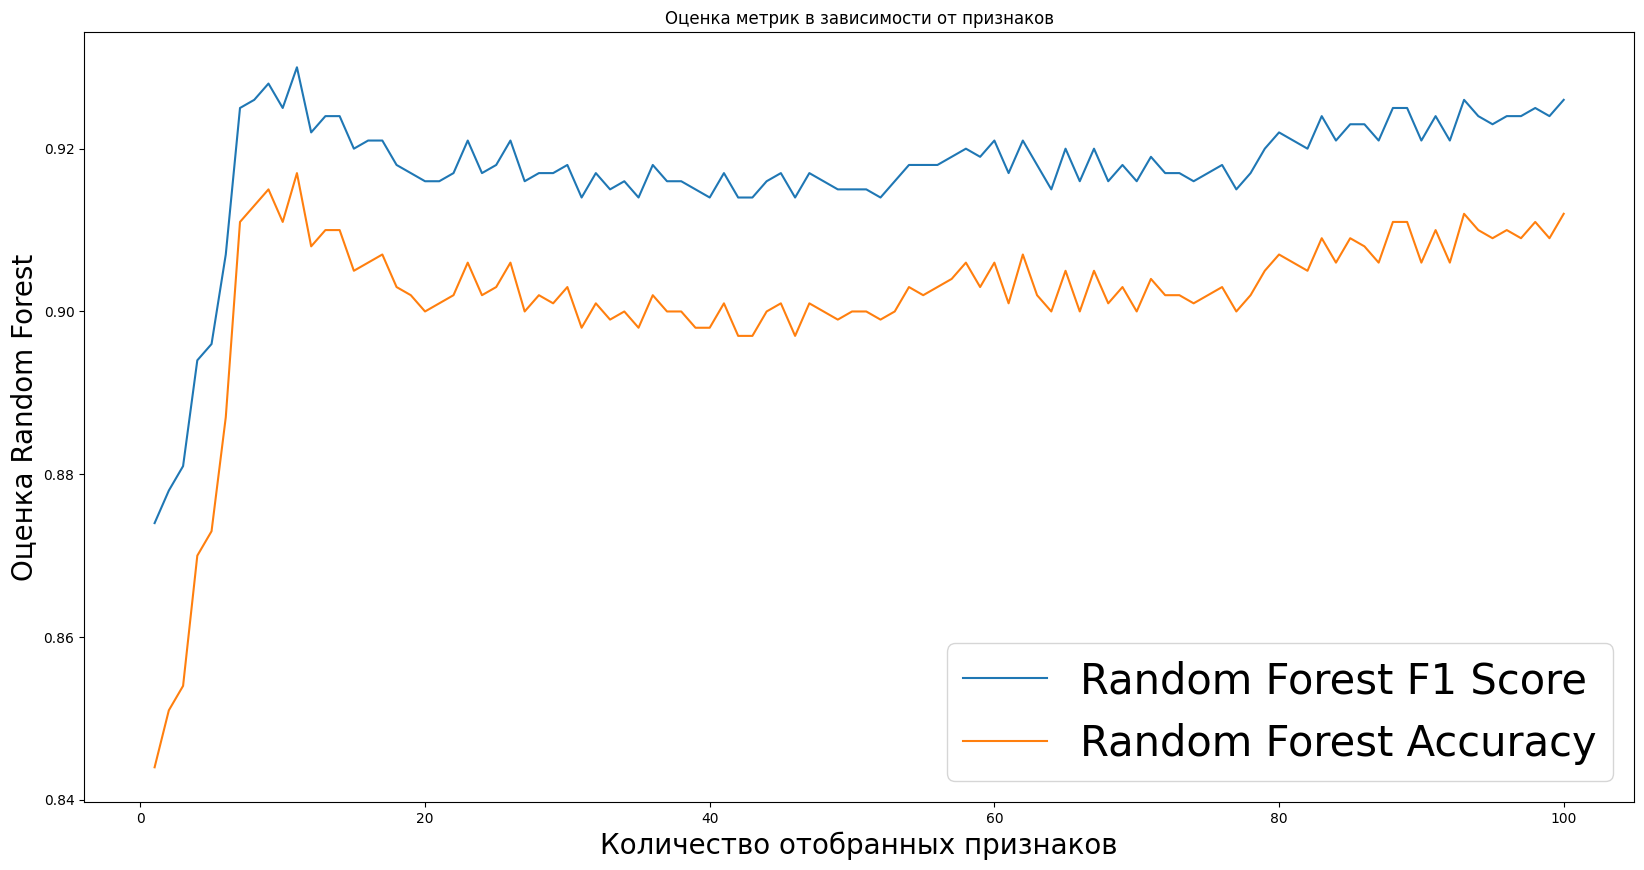

In [314]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_1_100.index, bst_features_1_100['Random forest F1 Score'], label='Random Forest F1 Score')
plt.plot(bst_features_1_100.index, bst_features_1_100['Random forest Accuracy'], label='Random Forest Accuracy')

plt.legend(prop={'size': 30})

Сократим с 1-100 до 5-30

In [315]:
bst_features_5_30 = score_from_n_to_m_best_features(5, 30)
bst_features_5_30

,Random forest F1 Score,Random forest Accuracy
5,0.898,0.876
6,0.909,0.889
7,0.922,0.907
8,0.923,0.908
9,0.924,0.91
10,0.924,0.91
11,0.927,0.913
12,0.925,0.911
13,0.924,0.91
14,0.924,0.91


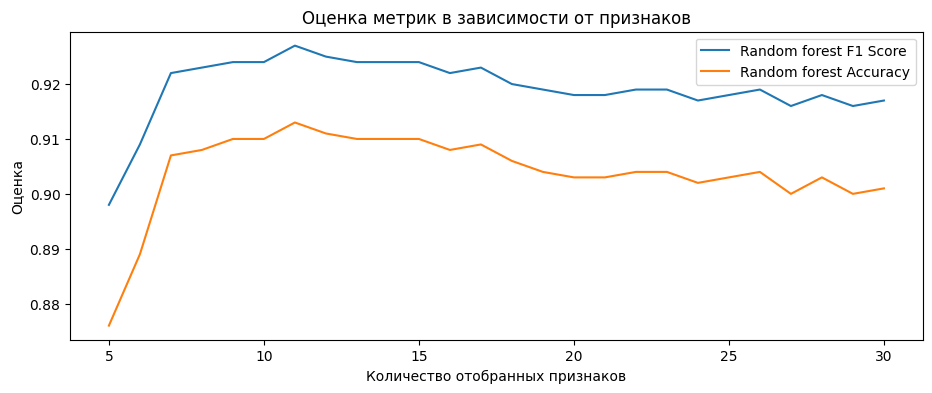

In [316]:
plt.figure(figsize=(11, 4))
#plt.xticks(rotation=30)

plt.ylabel("Oценка")
plt.xlabel("Количество отобранных признаков")

plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_5_30.index, bst_features_5_30['Random forest F1 Score'], label='Random forest F1 Score')
plt.plot(bst_features_5_30.index, bst_features_5_30['Random forest Accuracy'], label='Random forest Accuracy')

plt.legend()

Сократим с 5-30 до 5-15

In [317]:
bst_features_5_15 = score_from_n_to_m_best_features(5, 15)
bst_features_5_15

,Random forest F1 Score,Random forest Accuracy
5,0.9,0.878
6,0.911,0.892
7,0.922,0.908
8,0.928,0.914
9,0.925,0.911
10,0.927,0.914
11,0.928,0.915
12,0.925,0.911
13,0.924,0.909
14,0.925,0.911


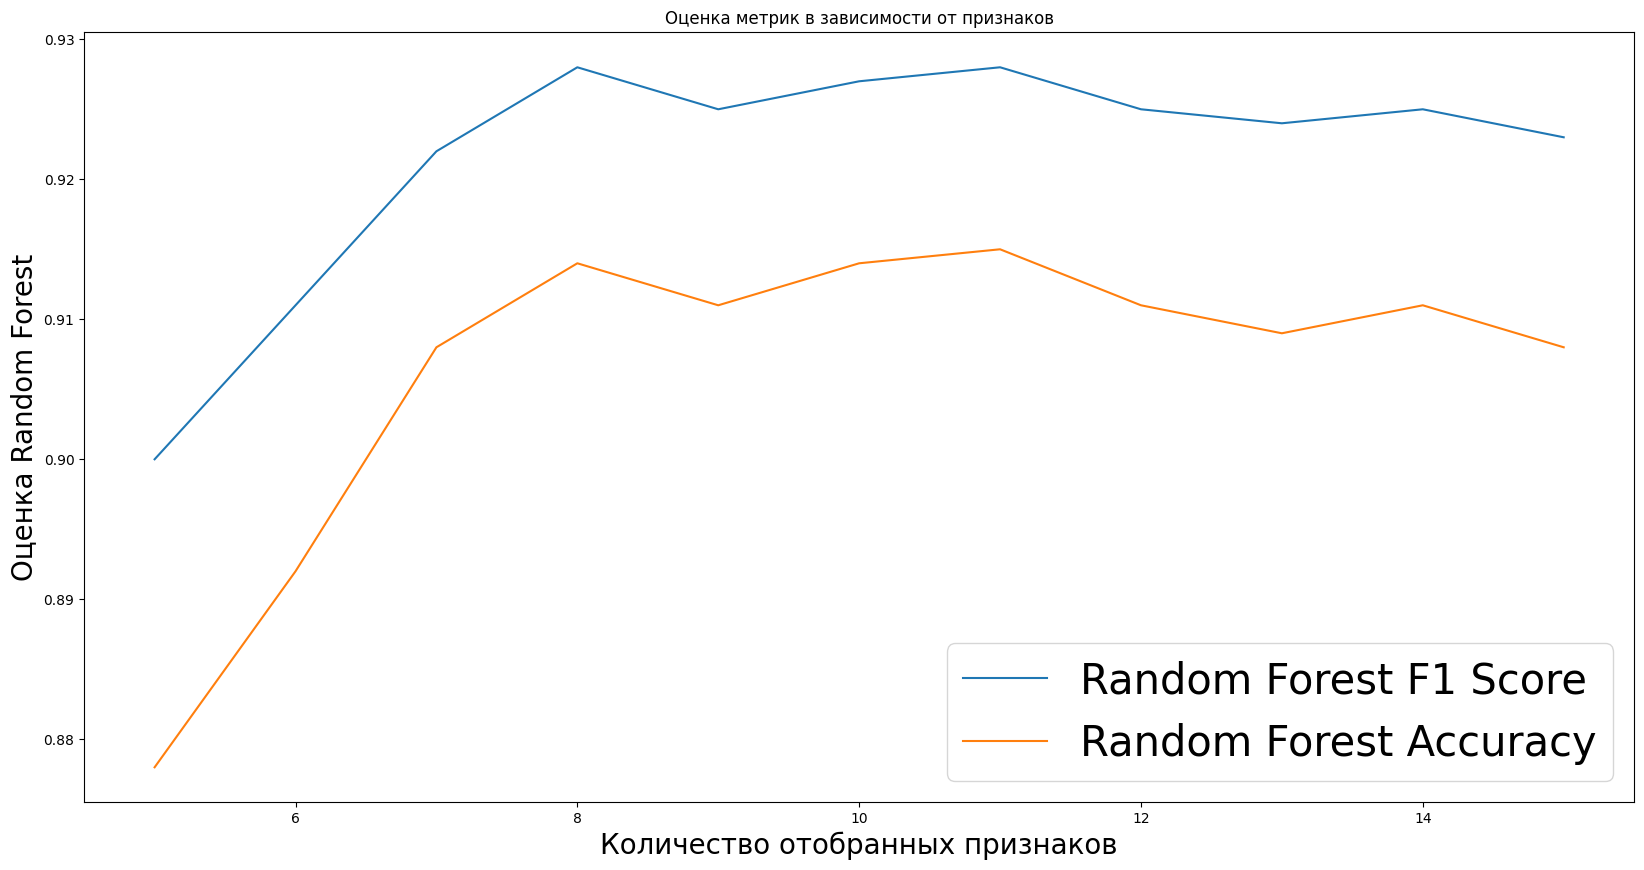

In [318]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_5_15.index, bst_features_5_15['Random forest F1 Score'], label='Random Forest F1 Score')
plt.plot(bst_features_5_15.index, bst_features_5_15['Random forest Accuracy'], label='Random Forest Accuracy')

plt.legend(prop={'size': 30})

Видно падение на 7 поэтому рассмотрим 6-12

In [319]:
bst_features_6_12 = score_from_n_to_m_best_features(6, 12)
bst_features_6_12

,Random forest F1 Score,Random forest Accuracy
6,0.913,0.894
7,0.926,0.912
8,0.924,0.91
9,0.928,0.914
10,0.925,0.911
11,0.926,0.912
12,0.926,0.912


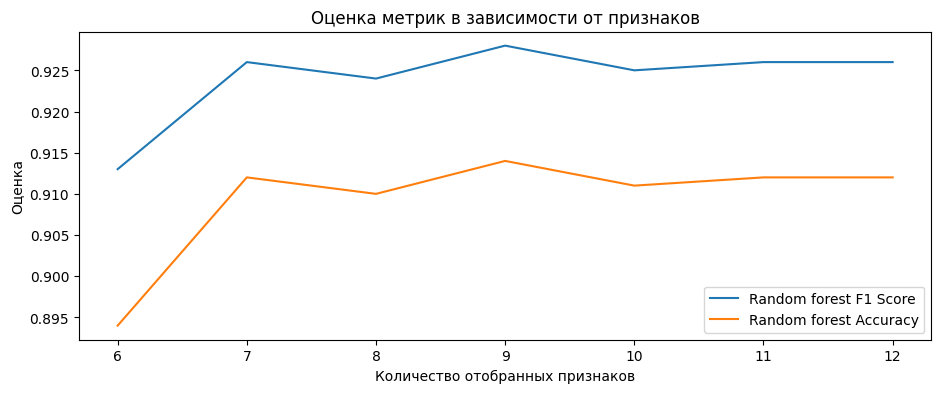

In [320]:
plt.figure(figsize=(11, 4))
#plt.xticks(rotation=30)

plt.ylabel("Oценка")
plt.xlabel("Количество отобранных признаков")

plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_6_12.index, bst_features_6_12['Random forest F1 Score'], label='Random forest F1 Score')
plt.plot(bst_features_6_12.index, bst_features_6_12['Random forest Accuracy'], label='Random forest Accuracy')

plt.legend()

Проведя серию экспериментов, с усредненными результатами, видно что идеальным выбором будет 7 либо 10 признаков

Рассмотрим метрики на 7 и 10 признаках

In [321]:
df_best_7_features = df_best_n_features(7)
df_best_7_features

,2276,2254,2282,2316,2290,2310,3273,target
0,561302.500000,561755.000000,564330.250000,569547.250000,564855.437500,568009.125000,618386.500000,0
1,15557.718750,15460.772461,15362.963867,15831.852539,15535.037109,15615.184570,17980.449219,0
2,30337.593750,30585.800781,30741.671875,29856.480469,30144.746094,30282.224609,20352.205078,0
3,23190.402344,23482.357422,23307.572266,23443.632813,23121.666016,23082.806641,16854.656250,0
4,308233.843750,306788.687500,309479.593750,314356.000000,309776.656250,314903.781250,371700.531250,0
...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22309.355469,22260.986328,29712.716797,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22549.919922,22210.582031,29519.359375,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22576.496094,22188.423828,29581.453125,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22732.476563,22215.191406,29818.916016,1


In [322]:
X_7 = df_best_7_features.drop(['target'], axis=1)
y_7 = df_best_7_features['target']

X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_7, y_7, test_size=0.2, random_state=42)

In [323]:
RF.fit(X_train_7, y_train_7)
y_pred_rf_7 = RF.predict(X_test_7)

cm_rf_7 = pd.DataFrame(confusion_matrix(y_test, y_pred_rf_7))
sensitivity = cm_rf_7[0][0] / (cm_rf_7[0][0] + cm_rf_7[1][0])
specificity = cm_rf_7[1][1] / (cm_rf_7[0][1] + cm_rf_7[1][1])

RF_7_metric = [accuracy_score(y_test_7, y_pred_rf_7), f1_score(y_test_7, y_pred_rf_7), specificity, sensitivity]
RF_7_metric

[0.9121951219512195,
 0.9256198347107438,
 0.9032258064516129,
 0.9259259259259259]

In [324]:
RF.fit(X_train_10, y_train_10)
y_pred_rf_10 = RF.predict(X_test_10)

cm_rf_10 = pd.DataFrame(confusion_matrix(y_test, y_pred_rf_10))
sensitivity = cm_rf_10[0][0] / (cm_rf_10[0][0] + cm_rf_10[1][0])
specificity = cm_rf_10[1][1] / (cm_rf_10[0][1] + cm_rf_10[1][1])

RF_10_metric = [accuracy_score(y_test_10, y_pred_rf_10), f1_score(y_test_10, y_pred_rf_10), specificity, sensitivity]
RF_10_metric

[0.9170731707317074,
 0.9300411522633745,
 0.9112903225806451,
 0.9259259259259259]

In [325]:
res_all['RF_best_7'] = RF_7_metric
res_all['RF_best_10'] = RF_10_metric

res_all = res_all.round(3)
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,RF_best_7,RF_best_10
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907,0.928,0.928,0.928,0.912,0.917
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918,0.938,0.938,0.938,0.926,0.930
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863,0.942,0.943,0.945,0.903,0.911
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975,0.909,0.908,0.903,0.926,0.926


In [326]:
res_RF_best = res_all.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_3', 'ENS_4',	'ENS_5',	'K_means_1',	'K_means_2',	'K_means_3'])
res_RF_best

,RF,RF_best_7,RF_best_10
Точность,0.917,0.912,0.917
F1 мера,0.931,0.926,0.930
Доля верно обнаруженных больных,0.919,0.903,0.911
Доля верно обнаруженных здоровых,0.914,0.926,0.926


In [327]:
res_RF_best.to_csv('results/result_RF_best.csv') 

## 5.2. ExhaustiveFeatureSelector

Рассмотрим все комбинации от 6 до 8 из 10 самых информативных Raman Shift

In [328]:
import joblib
import sklearn

sklearn.externals.joblib = joblib

print(sklearn.externals.joblib)

<module 'joblib' from 'c:\\Users\\DIMEDROL\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\joblib\\__init__.py'>


In [329]:
import sys

sys.modules['sklearn.externals.joblib'] = joblib

In [330]:
df_best_10_features = df_best_n_features(10)

X_10 = df_best_10_features.drop(['target'], axis=1)
y_10 = df_best_10_features['target']

X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=42)

In [331]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import GradientBoostingClassifier

# создаем ExhaustiveFeatureSeLlector объект.
efs = ExhaustiveFeatureSelector(RandomForestClassifier(),
        min_features=6,
        max_features=8,
        scoring='f1',
        cv=2)

efs = efs.fit(X_train_10, y_train_10)

# выводим выбранные признаки
selected_features = X_train_10.columns[list(efs.best_idx_)]
print(selected_features)

Features: 375/375

Index([2282, 2290, 2310, 3273, 2313, 2305, 2271], dtype='object')


In [332]:
df_t = df.T
df_efs = df_t.loc[selected_features]
df_efs = df_efs.T
df_efs['target'] = df.target
df_efs

,2282,2290,2310,3273,2313,2305,2271,target
0,564330.250000,564855.437500,568009.125000,618386.500000,568908.500000,567538.375000,561950.437500,0
1,15362.963867,15535.037109,15615.184570,17980.449219,15863.120117,15673.658203,15418.387695,0
2,30741.671875,30144.746094,30282.224609,20352.205078,30439.154297,30224.330078,30258.583984,0
3,23307.572266,23121.666016,23082.806641,16854.656250,23272.167969,23201.140625,23196.888672,0
4,309479.593750,309776.656250,314903.781250,371700.531250,314343.375000,314481.250000,308379.781250,0
...,...,...,...,...,...,...,...,...
1017,22770.496094,22309.355469,22260.986328,29712.716797,22015.281250,22215.191406,22600.001953,1
1018,22337.785156,22549.919922,22210.582031,29519.359375,22305.763672,22454.488281,22568.464844,1
1019,22431.828125,22576.496094,22188.423828,29581.453125,22260.986328,22306.289063,22372.314453,1
1020,22447.140625,22732.476563,22215.191406,29818.916016,22210.582031,22126.199219,22655.052734,1


In [333]:
X_efs1 = df_efs.drop(['target'], axis=1)
y_efs1 = df_efs['target']

X_efs1_train, X_efs1_test, y_efs1_train, y_efs1_test = train_test_split(X_efs1, y_efs1, test_size=0.2, random_state=42)

In [334]:
RF = RandomForestClassifier()
RF.fit(X_efs1_train, y_efs1_train)
y_pred_efs1 = RF.predict(X_efs1_test)

cm_rf_efs = pd.DataFrame(confusion_matrix(y_efs1_test, y_pred_efs1))
sensitivity = cm_rf_efs[0][0] / (cm_rf_efs[0][0] + cm_rf_efs[1][0])
specificity = cm_rf_efs[1][1] / (cm_rf_efs[0][1] + cm_rf_efs[1][1])

RF_EFS_1_metric = [accuracy_score(y_efs1_test, y_pred_efs1), f1_score(y_efs1_test, y_pred_efs1), specificity, sensitivity]
RF_EFS_1_metric

[0.8926829268292683,
 0.9083333333333334,
 0.8790322580645161,
 0.9135802469135802]

рассмотрим все комбинации от 8 до 10 из 12 самых информативных Raman Shift

In [335]:
df_best_12_features = df_best_n_features(12)

X_12 = df_best_12_features.drop(['target'], axis=1)
y_12 = df_best_12_features['target']

X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X_12, y_12, test_size=0.2, random_state=42)

In [336]:
# создаем ExhaustiveFeatureSeLlector объект.
efs = ExhaustiveFeatureSelector(RandomForestClassifier(),
        min_features=8,
        max_features=10,
        scoring='roc_auc',
        cv=2)

efs = efs.fit(X_train_12, y_train_12)

# выводим выбранные признаки
selected_features = X_train_12.columns[list(efs.best_idx_)]
print(selected_features)

Features: 781/781

Index([2276, 2254, 2282, 2316, 2310, 3273, 2305, 2271, 2322], dtype='object')


In [337]:
feature_importances.head(12)

,Importance,Raman Shift
0,0.448217,2276
1,0.444072,2254
2,0.441974,2282
3,0.441940,2316
4,0.439378,2290
5,0.438947,2310
6,0.438489,3273
7,0.437978,2313
8,0.437977,2305
9,0.437477,2271


In [338]:
df_t = df.T
df_efs = df_t.loc[selected_features]
df_efs = df_efs.T
df_efs['target'] = df.target
df_efs

,2276,2254,2282,2316,2310,3273,2305,2271,2322,target
0,561302.500000,561755.000000,564330.250000,569547.250000,568009.125000,618386.500000,567538.375000,561950.437500,568058.250000,0
1,15557.718750,15460.772461,15362.963867,15831.852539,15615.184570,17980.449219,15673.658203,15418.387695,15565.156250,0
2,30337.593750,30585.800781,30741.671875,29856.480469,30282.224609,20352.205078,30224.330078,30258.583984,29926.781250,0
3,23190.402344,23482.357422,23307.572266,23443.632813,23082.806641,16854.656250,23201.140625,23196.888672,23179.843750,0
4,308233.843750,306788.687500,309479.593750,314356.000000,314903.781250,371700.531250,314481.250000,308379.781250,314384.156250,0
...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22600.992188,22770.496094,22315.832031,22260.986328,29712.716797,22215.191406,22600.001953,22142.505859,1
1018,22541.402344,22647.896484,22337.785156,22474.501953,22210.582031,29519.359375,22454.488281,22568.464844,22233.488281,1
1019,22521.099609,22500.722656,22431.828125,22015.281250,22188.423828,29581.453125,22306.289063,22372.314453,22188.679688,1
1020,22600.001953,22652.085938,22447.140625,22305.763672,22215.191406,29818.916016,22126.199219,22655.052734,22373.847656,1


In [339]:
X_efs2 = df_efs.drop(['target'], axis=1)
y_efs2 = df_efs['target']

X_efs2_train, X_efs2_test, y_efs2_train, y_efs2_test = train_test_split(X_efs2, y_efs2, test_size=0.2, random_state=42)

In [340]:
RF.fit(X_efs2_train, y_efs2_train)
y_pred_efs2 = RF.predict(X_efs2_test)

cm_rf_efs = pd.DataFrame(confusion_matrix(y_efs2_test, y_pred_efs2))
sensitivity = cm_rf_efs[0][0] / (cm_rf_efs[0][0] + cm_rf_efs[1][0])
specificity = cm_rf_efs[1][1] / (cm_rf_efs[0][1] + cm_rf_efs[1][1])

RF_EFS_2_metric = [accuracy_score(y_efs2_test, y_pred_efs2), f1_score(y_efs2_test, y_pred_efs2), specificity, sensitivity]
RF_EFS_2_metric

[0.926829268292683, 0.9382716049382716, 0.9193548387096774, 0.9382716049382716]

In [341]:
res_all['RF_EFS_1_6'] = RF_EFS_1_metric
res_all['RF_EFS_2_9'] = RF_EFS_2_metric

res_all = res_all.round(3)
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,RF_best_7,RF_best_10,RF_EFS_1_6,RF_EFS_2_9
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907,0.928,0.928,0.928,0.912,0.917,0.893,0.927
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918,0.938,0.938,0.938,0.926,0.930,0.908,0.938
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863,0.942,0.943,0.945,0.903,0.911,0.879,0.919
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975,0.909,0.908,0.903,0.926,0.926,0.914,0.938


In [342]:
res_RF_EFS = res_all.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_3', 'ENS_4',	'ENS_5',	'K_means_1',	'K_means_2',	'K_means_3', 'RF_best_7', 'RF_best_10'])
res_RF_EFS

,RF,RF_EFS_1_6,RF_EFS_2_9
Точность,0.917,0.893,0.927
F1 мера,0.931,0.908,0.938
Доля верно обнаруженных больных,0.919,0.879,0.919
Доля верно обнаруженных здоровых,0.914,0.914,0.938


In [343]:
res_RF_EFS.to_csv('results/result_RF_EFS.csv') 

## 5.3. RFE

In [344]:
from sklearn import preprocessing

from sklearn.feature_selection import RFE

In [345]:
def rfe_from_n_to_m_best_features_on_k_features(n, m, k):

  rfe_bst_features = pd.DataFrame(index=range(n, m + 1),columns=['RFE F1 Score', 'RFE Accuracy'])

  df_best_k_features = df_best_n_features(k)

  X_k = df_best_k_features.drop(['target'], axis=1)
  y_k = df_best_k_features['target']

  X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y_k, test_size=0.2, random_state=42)

  for i in range (n, m + 1):

    _lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42, n_jobs=-1, max_iter=10)

    rfe = RFE(_lr, n_features_to_select=i)
    rfe.fit(X_train_k, y_train_k)
    # X_train, y_train - входные и выходные данные с обучающей выборки соответственно.
    y_pred_rfe = rfe.predict(X_test_k)

    f1_score_i = f1_score(y_test_k, y_pred_rfe)
    accuracy_i = accuracy_score(y_test_k, y_pred_rfe)

    #rfe_bst_features['RFE F1 Score'][i] = round(f1_score_i, 3)
    #rfe_bst_features['RFE Accuracy'][i] = round(accuracy_i, 3)

    rfe_bst_features['RFE F1 Score'][i] = f1_score_i
    rfe_bst_features['RFE Accuracy'][i] = accuracy_i
  return(rfe_bst_features)

In [346]:
bst_features_1_50 = rfe_from_n_to_m_best_features_on_k_features(1, 50, 50)
bst_features_1_50

,RFE F1 Score,RFE Accuracy
1,0.0,0.395122
2,0.894737,0.882927
3,0.894737,0.882927
4,0.894737,0.882927
5,0.899563,0.887805
6,0.899563,0.887805
7,0.894737,0.882927
8,0.899563,0.887805
9,0.887931,0.873171
10,0.895652,0.882927


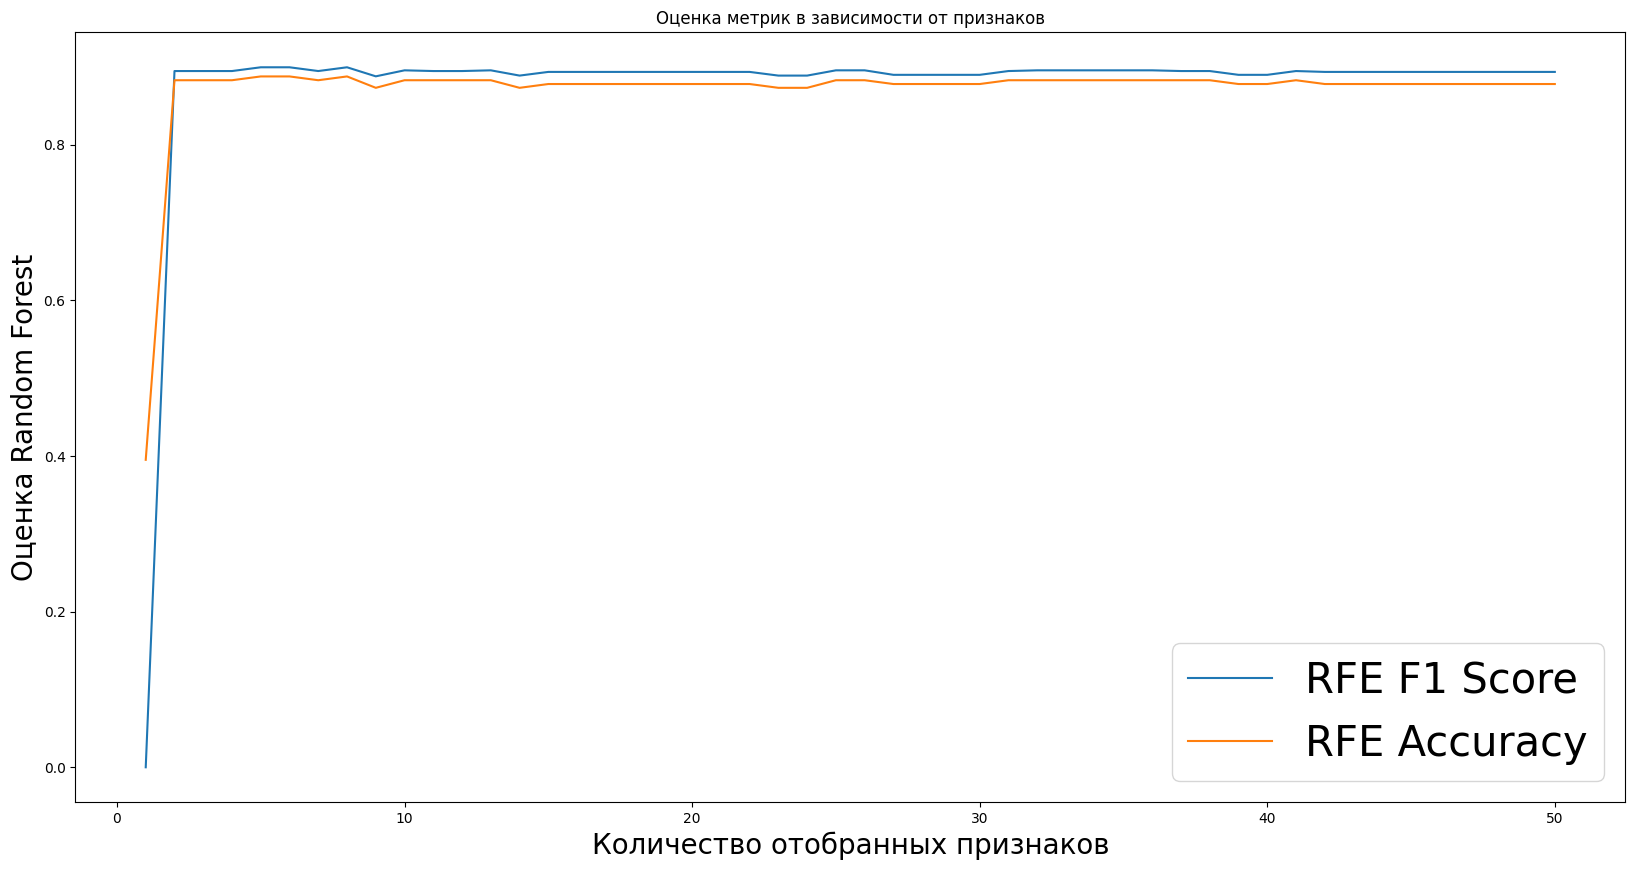

In [347]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_1_50.index, bst_features_1_50['RFE F1 Score'], label='RFE F1 Score')
plt.plot(bst_features_1_50.index, bst_features_1_50['RFE Accuracy'], label='RFE Accuracy')

plt.legend(prop={'size': 30})

In [348]:
bst_features_5_30 = rfe_from_n_to_m_best_features_on_k_features(3, 30, 50)
bst_features_5_30

,RFE F1 Score,RFE Accuracy
3,0.894737,0.882927
4,0.894737,0.882927
5,0.899563,0.887805
6,0.899563,0.887805
7,0.894737,0.882927
8,0.899563,0.887805
9,0.887931,0.873171
10,0.895652,0.882927
11,0.894737,0.882927
12,0.894737,0.882927


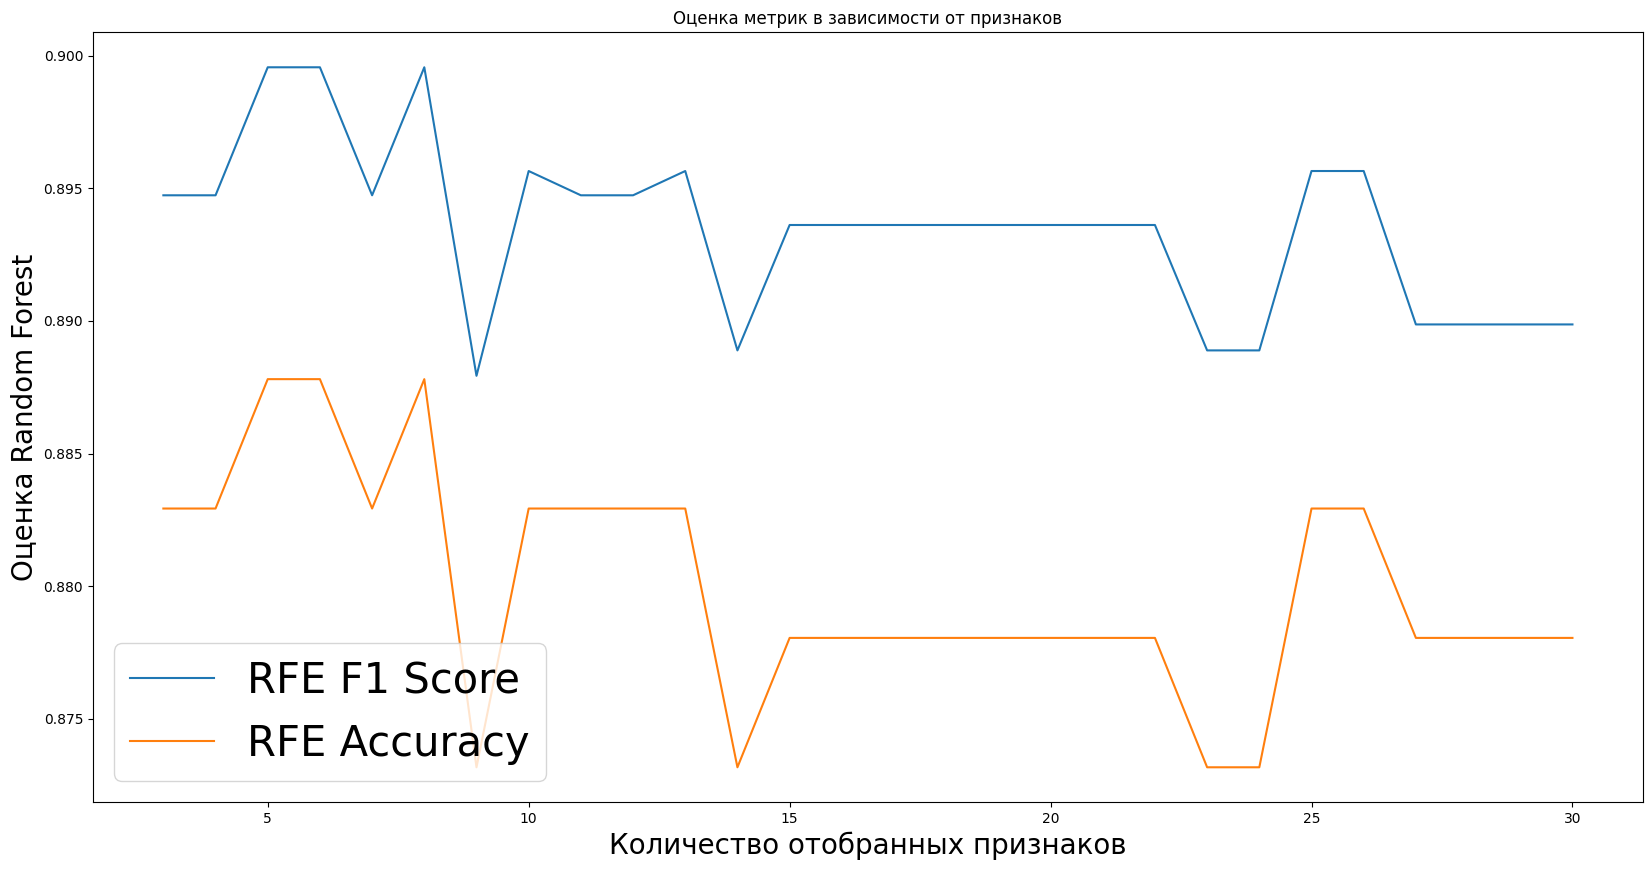

In [349]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)


plt.title('Оценка метрик в зависимости от признаков')

plt.plot(bst_features_5_30.index, bst_features_5_30['RFE F1 Score'], label='RFE F1 Score')
plt.plot(bst_features_5_30.index, bst_features_5_30['RFE Accuracy'], label='RFE Accuracy')

plt.legend(prop={'size': 30})

Теперь посмотрим какие признаки встречались чаще всего

In [350]:
def get_best_features(n, m, k):

  get_bst_features = pd.DataFrame(0, index=range(1, k + 1), columns=['Sum'])

  df_best_k_features = df_best_n_features(k)
  X_k = df_best_k_features.drop(['target'], axis=1)
  y_k = df_best_k_features['target']

  X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_k, y_k, test_size=0.2, random_state=42)

  for i in range (n, m + 1):

    _lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42, n_jobs=-1, max_iter=10)

    rfe = RFE(_lr, n_features_to_select=i)
    rfe.fit(X_train_k, y_train_k)
    # X_train, y_train - входные и выходные данные с обучающей выборки соответственно.
    y_pred_rfe = rfe.predict(X_test_k)

    F = pd.DataFrame(rfe.support_)
    F = F.astype(int)
    get_bst_features['Sum'] += F[0]  
  return(get_bst_features)

In [351]:
get_bst_features_5_20 = get_best_features(5, 15, 20)
feat = feature_importances.head(20)
best_20_ftr_list = list(feat['Raman Shift'])
get_bst_features_5_20.index = best_20_ftr_list
get_bst_features_5_20 = get_bst_features_5_20.sort_values(by='Sum', ascending=False)
get_bst_features_5_20.head(10)

,Sum
2276,11.0
2310,11.0
2188,11.0
2305,11.0
2297,11.0
2254,10.0
2296,8.0
2317,7.0
2313,6.0
2322,5.0


In [352]:
get_bst_features_5_20.head(10).index

Index([2276, 2310, 2188, 2305, 2297, 2254, 2296, 2317, 2313, 2322], dtype='int64')

In [353]:
ftr_list = [2276, 2310, 2188, 2313, 2297, 2254, 2296, 2317, 2262, 3273]
df_t = df.T
df_rfe = df_t.loc[ftr_list]
df_rfe = df_rfe.T
df_rfe['target'] = df.target
df_rfe

,2276,2310,2188,2313,2297,2254,2296,2317,2262,3273,target
0,561302.500000,568009.125000,562224.812500,568908.500000,567815.750000,561755.000000,565794.875000,569294.562500,561578.687500,618386.500000,0
1,15557.718750,15615.184570,15395.332031,15863.120117,15758.320313,15460.772461,15701.825195,16016.805664,15405.868164,17980.449219,0
2,30337.593750,30282.224609,31876.123047,30439.154297,30406.583984,30585.800781,30189.017578,30193.044922,30475.548828,20352.205078,0
3,23190.402344,23082.806641,23868.478516,23272.167969,23376.064453,23482.357422,23293.023438,23038.597656,23300.998047,16854.656250,0
4,308233.843750,314903.781250,302984.062500,314343.375000,312833.406250,306788.687500,311677.906250,315157.250000,307880.125000,371700.531250,0
...,...,...,...,...,...,...,...,...,...,...,...
1017,22430.601563,22260.986328,22324.660156,22015.281250,22523.562500,22600.992188,22377.355469,22373.847656,22667.013672,29712.716797,1
1018,22541.402344,22210.582031,22356.267578,22305.763672,22377.355469,22647.896484,22364.574219,22315.832031,22682.205078,29519.359375,1
1019,22521.099609,22188.423828,22443.265625,22260.986328,22364.574219,22500.722656,22333.017578,22474.501953,22564.750000,29581.453125,1
1020,22600.001953,22215.191406,22692.705078,22210.582031,22333.017578,22652.085938,22258.292969,22015.281250,22385.714844,29818.916016,1


In [354]:
X_rfe = df_rfe.drop(['target'], axis=1)
y_rfe = df_rfe['target']

X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.2, random_state=42)

In [355]:
RF = RandomForestClassifier()
RF.fit(X_rfe_train, y_rfe_train)
y_pred_rfe = RF.predict(X_rfe_test)

cm_rf_rfe = pd.DataFrame(confusion_matrix(y_rfe_test, y_pred_rfe))
sensitivity = cm_rf_rfe[0][0] / (cm_rf_rfe[0][0] + cm_rf_rfe[1][0])
specificity = cm_rf_rfe[1][1] / (cm_rf_rfe[0][1] + cm_rf_rfe[1][1])

RF_RFE_metric = [accuracy_score(y_rfe_test, y_pred_rfe), f1_score(y_rfe_test, y_pred_rfe), specificity, sensitivity]
RF_RFE_metric

[0.9073170731707317, 0.921161825726141, 0.8951612903225806, 0.9259259259259259]

In [356]:
res_all['RFE'] = RF_RFE_metric
res_all = res_all.round(3)
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,RF_best_7,RF_best_10,RF_EFS_1_6,RF_EFS_2_9,RFE
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907,0.928,0.928,0.928,0.912,0.917,0.893,0.927,0.907
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918,0.938,0.938,0.938,0.926,0.930,0.908,0.938,0.921
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863,0.942,0.943,0.945,0.903,0.911,0.879,0.919,0.895
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975,0.909,0.908,0.903,0.926,0.926,0.914,0.938,0.926


In [357]:
res_RF_RFE = res_all.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_3', 'ENS_4',	'ENS_5',	'K_means_1',	'K_means_2',	'K_means_3', 'RF_best_7', 'RF_best_10', 'RF_EFS_1_6', 'RF_EFS_2_9'])
res_RF_RFE

,RF,RFE
Точность,0.917,0.907
F1 мера,0.931,0.921
Доля верно обнаруженных больных,0.919,0.895
Доля верно обнаруженных здоровых,0.914,0.926


In [358]:
res_RF_RFE.to_csv('results/result_RF_RFE.csv') 

## 5.4. Random Forest Importance

In [359]:
# создаем случайное дерево с вашими гипер параметрами
model = RandomForestClassifier(n_estimators=100)

# Обучаем модель на вашей выборке; Где X, y - входные и выходные данные соответственно.
model.fit(X, y)

# Подбираем самые важные признаки
importances = model.feature_importances_

# Создаем отдельный датасет для визуализации
final_df = pd.DataFrame({"Raman Shift" : pd.DataFrame(X).columns, "Importances" : importances})
final_df

,Raman Shift,Importances
0,2141,0.009294
1,2142,0.024467
2,2144,0.019645
3,2145,0.007674
4,2147,0.011781
...,...,...
1010,3545,0.004468
1011,3546,0.000292
1012,3547,0.001368
1013,3549,0.001887


<Axes: xlabel='Raman Shift'>

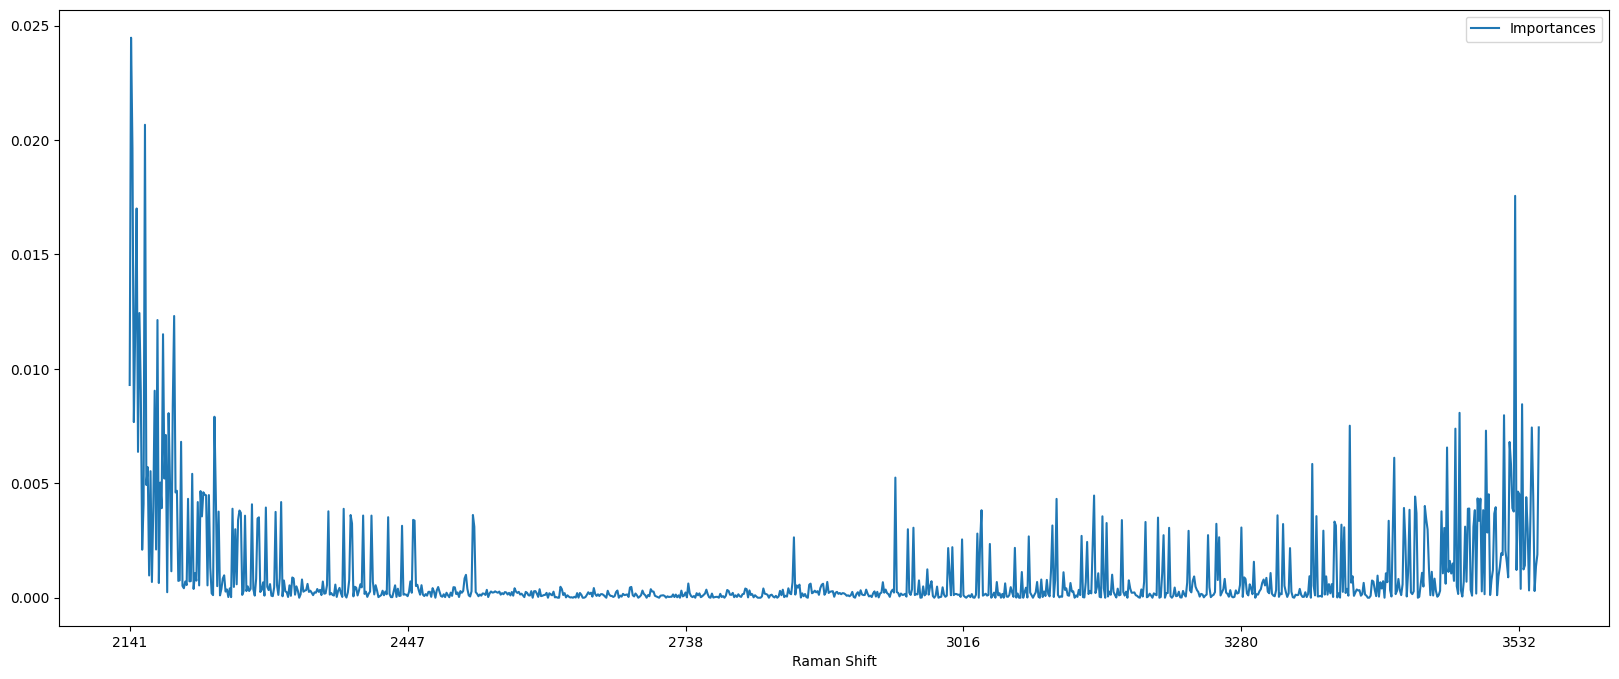

In [360]:
final_df.plot(x = 'Raman Shift', y = 'Importances', figsize=(20, 8))

In [361]:
final_df_sort = final_df.sort_values(by=['Importances'], ascending=False)
final_df_sort

,Raman Shift,Importances
1,2142,0.024467
11,2158,0.020663
2,2144,0.019645
997,3529,0.017557
5,2149,0.017006
...,...,...
309,2608,0.000000
407,2748,0.000000
718,3173,0.000000
620,3043,0.000000


In [362]:
def df_best_n_features_rfi(n):

  n_features = final_df_sort.head(n)
  best_n_ftr_list = list(n_features['Raman Shift'])

  df_t = df.T
  df_best_n_features = df_t.loc[best_n_ftr_list]
  df_best_n_features = df_best_n_features.T
  df_best_n_features['target'] = df.target

  return(df_best_n_features)

In [363]:
def score_from_n_to_m_best_features_rfi(n, m):

  bst_features = pd.DataFrame(index=range(n, m + 1),columns=['RFI F1 Score', 'RFI Accuracy'])

  for i in range (n, m + 1):

    f1_score_i = 0
    accuracy_i = 0

    df_best_i_features = df_best_n_features_rfi(i)

    for j in range (10):
      X_i = df_best_i_features.drop(['target'], axis=1)
      y_i = df_best_i_features['target']
      X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.2, random_state=42)

      RF = RandomForestClassifier()
      RF.fit(X_train_i, y_train_i)
      y_pred_rf_i = RF.predict(X_test_i)
      f1_score_i += f1_score(y_test_i, y_pred_rf_i)
      accuracy_i += accuracy_score(y_test_i, y_pred_rf_i)

    bst_features['RFI F1 Score'][i] = round(f1_score_i / 10, 3)
    bst_features['RFI Accuracy'][i] = round(accuracy_i / 10, 3)

  return(bst_features)

In [364]:
rfi_1_50 = score_from_n_to_m_best_features_rfi(1, 50)
rfi_1_50

,RFI F1 Score,RFI Accuracy
1,0.841,0.815
2,0.871,0.85
3,0.867,0.845
4,0.916,0.902
5,0.918,0.905
6,0.918,0.904
7,0.917,0.902
8,0.916,0.902
9,0.916,0.901
10,0.917,0.903


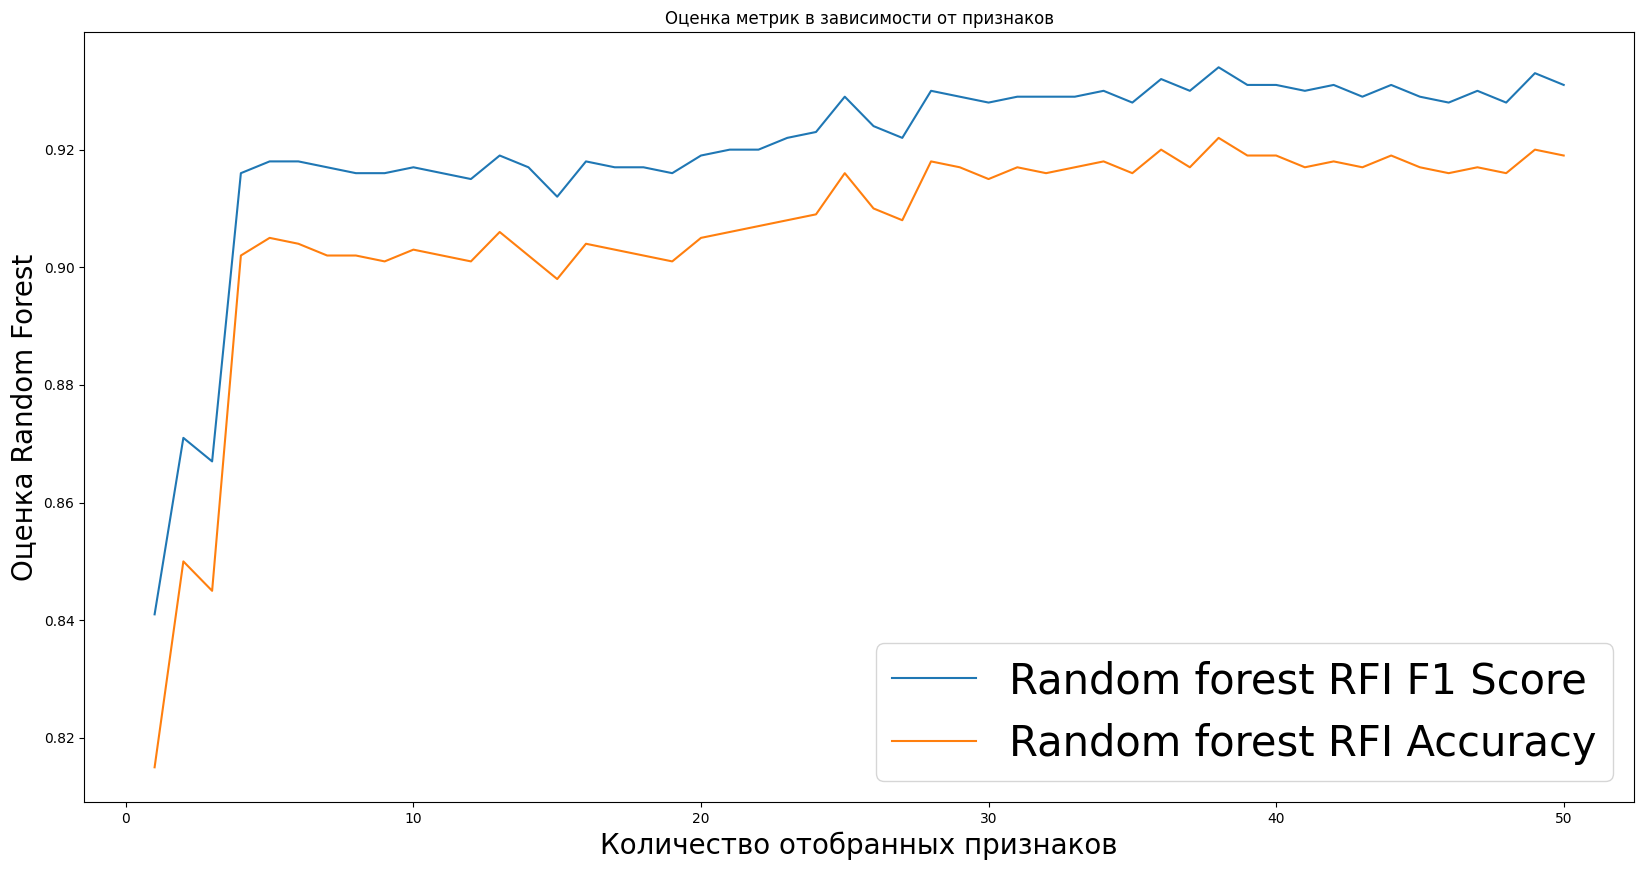

In [365]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

plt.title('Оценка метрик в зависимости от признаков')

plt.plot(rfi_1_50.index, rfi_1_50['RFI F1 Score'], label='Random forest RFI F1 Score')
plt.plot(rfi_1_50.index, rfi_1_50['RFI Accuracy'], label='Random forest RFI Accuracy')

plt.legend(prop={'size': 30})

In [366]:
rfi_7_15 = score_from_n_to_m_best_features_rfi(7, 15)
rfi_7_15

,RFI F1 Score,RFI Accuracy
7,0.916,0.901
8,0.915,0.9
9,0.916,0.902
10,0.915,0.901
11,0.918,0.905
12,0.918,0.904
13,0.917,0.904
14,0.914,0.899
15,0.913,0.899


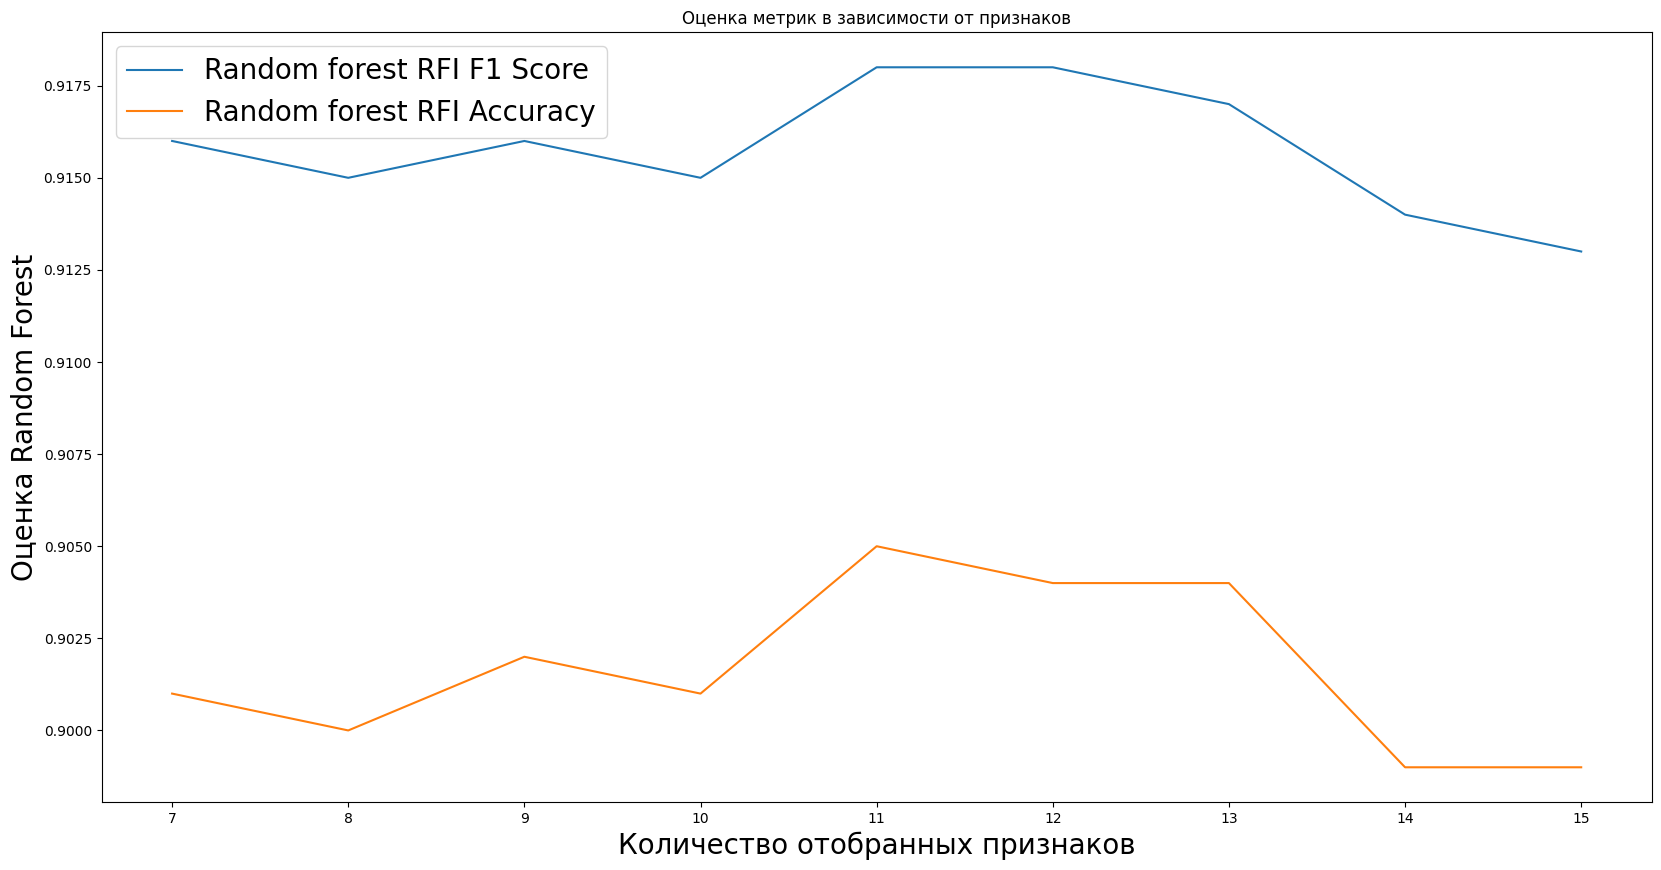

In [367]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество отобранных признаков", fontsize=20)

plt.title('Оценка метрик в зависимости от признаков')

plt.plot(rfi_7_15.index, rfi_7_15['RFI F1 Score'], label='Random forest RFI F1 Score')
plt.plot(rfi_7_15.index, rfi_7_15['RFI Accuracy'], label='Random forest RFI Accuracy')

plt.legend(prop={'size': 20})

In [368]:
rfi_9_features = df_best_n_features_rfi(9)
rfi_9_features

,2142,2158,2144,3529,2149,2152,2191,2172,2147,target
0,560870.375000,562267.625000,560753.125000,604243.875000,560453.625000,559917.562500,563206.375000,561708.437500,562715.687500,0
1,15260.290039,15466.633789,15221.147461,17619.642578,15260.236328,15175.439453,15258.469727,15360.125000,15187.541992,0
2,32444.185547,32165.476563,32329.664063,17764.369141,32270.251953,32186.328125,31741.394531,31963.363281,32662.951172,0
3,24479.248047,24187.746094,24512.789063,15049.352539,24298.597656,24156.138672,23901.826172,24137.009766,24344.998047,0
4,300626.875000,301965.750000,299604.843750,358230.375000,300457.968750,300483.593750,305062.125000,302719.562500,301127.500000,0
...,...,...,...,...,...,...,...,...,...,...
1017,22311.207031,22418.232422,22580.873047,30622.443359,22589.820313,22451.833984,22470.287109,22470.365234,22543.992188,1
1018,22480.119141,22377.912109,22311.207031,30500.001953,22543.992188,22507.066406,22385.443359,22630.841797,22512.871094,1
1019,22372.001953,22525.132813,22480.119141,30689.810547,22512.871094,22589.820313,22324.660156,22601.466797,22580.873047,1
1020,22623.326172,22666.765625,22372.001953,30655.017578,22580.873047,22543.992188,22356.267578,22583.154297,22311.207031,1


In [369]:
rfi_9_features.columns

Index([2142, 2158, 2144, 3529, 2149, 2152, 2191, 2172, 2147, 'target'], dtype='object')

In [370]:
X_rfi = rfi_9_features.drop(['target'], axis=1)
y_rfi = rfi_9_features['target']

X_rfi_train, X_rfi_test, y_rfi_train, y_rfi_test = train_test_split(X_rfi, y_rfi, test_size=0.2, random_state=42)

In [371]:
RF = RandomForestClassifier()
RF.fit(X_rfi_train, y_rfi_train)
y_pred_rfi = RF.predict(X_rfi_test)

cm_rf_rfi = pd.DataFrame(confusion_matrix(y_rfi_test, y_pred_rfi))
sensitivity = cm_rf_rfi[0][0] / (cm_rf_rfi[0][0] + cm_rf_rfi[1][0])
specificity = cm_rf_rfi[1][1] / (cm_rf_rfi[0][1] + cm_rf_rfi[1][1])

RF_RFI_metric = [accuracy_score(y_rfi_test, y_pred_rfi), f1_score(y_rfi_test, y_pred_rfi), specificity, sensitivity]
RF_RFI_metric

[0.8975609756097561,
 0.9121338912133892,
 0.8790322580645161,
 0.9259259259259259]

In [372]:
res_all['RFI'] = RF_RFI_metric
res_all = res_all.round(3)
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,RF_best_7,RF_best_10,RF_EFS_1_6,RF_EFS_2_9,RFE,RFI
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907,0.928,0.928,0.928,0.912,0.917,0.893,0.927,0.907,0.898
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918,0.938,0.938,0.938,0.926,0.930,0.908,0.938,0.921,0.912
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863,0.942,0.943,0.945,0.903,0.911,0.879,0.919,0.895,0.879
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975,0.909,0.908,0.903,0.926,0.926,0.914,0.938,0.926,0.926


In [373]:
res_RF_RFI = res_all.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_3', 'ENS_4',	'ENS_5',	'K_means_1',	'K_means_2',	'K_means_3', 'RF_best_7', 'RF_best_10', 'RF_EFS_1_6', 'RF_EFS_2_9', 'RFE'])
res_RF_RFI

,RF,RFI
Точность,0.917,0.898
F1 мера,0.931,0.912
Доля верно обнаруженных больных,0.919,0.879
Доля верно обнаруженных здоровых,0.914,0.926


In [374]:
res_RF_RFI.to_csv('results/result_RF_RFI.csv') 

## 5.5. PCA

In [375]:
from sklearn.decomposition import PCA

_data = df.drop(['target'], axis=1)

PCA_output = PCA(n_components=10)
PCA_output.fit(_data)
sklearn_transformed_data = PCA_output.transform(_data)

In [376]:
_PCA = pd.DataFrame(sklearn_transformed_data)
_PCA['target'] = df.target
_PCA

,0,1,2,3,4,5,6,7,8,9,target
0,1.766081e+07,420033.647486,586879.619326,108172.923606,-2864.280979,20603.474150,-18900.866829,3245.185930,-4713.626214,-10401.929229,0
1,-8.605752e+05,-34566.704385,-15620.447572,-492.110783,-5063.741179,2917.459977,-2655.959189,-1375.443331,-534.981479,-277.040871,0
2,-6.429806e+05,133933.474893,-2165.272228,3317.402367,-1471.773186,1209.023528,-1062.801099,-253.369962,-30.841675,1906.149386,0
3,-7.862992e+05,79569.495757,-13951.518693,-3354.307939,-2071.691367,624.750701,-361.964704,-695.171230,192.073774,1031.242388,0
4,9.923238e+06,-110514.359677,30.772681,-18275.177326,4605.277203,-4181.049181,8742.374560,-1540.317751,708.102547,-11999.917362,0
...,...,...,...,...,...,...,...,...,...,...,...
1017,-5.751925e+05,-98758.662750,442.984842,51719.692879,-22688.276456,14987.848797,-8300.561844,-2877.985344,-3418.066311,-5621.433195,1
1018,-5.754527e+05,-98671.440477,540.103820,51690.929583,-22799.008067,15031.996430,-8547.222919,-2769.791369,-3429.803818,-5470.204670,1
1019,-5.757118e+05,-98564.445260,640.704921,51672.159210,-22893.002658,15087.330344,-8791.701294,-2657.098545,-3430.552451,-5213.893789,1
1020,-5.759608e+05,-98455.140645,760.116350,51663.064032,-22961.365138,15132.696567,-9000.311880,-2536.420466,-3411.104252,-4961.867975,1


In [377]:
X_pca = _PCA.drop(['target'], axis=1)
y_pca = _PCA['target']
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [378]:
RF = RandomForestClassifier()
RF.fit(X_train_pca, y_train_pca)

RandomForestClassifier()

In [379]:
y_pred_rf = RF.predict(X_test_pca)

print(f'Random forest F1 Score {f1_score(y_test_pca, y_pred_rf)}')
print(f'Random forest Accuracy {accuracy_score(y_test_pca, y_pred_rf)}')

Random forest F1 Score 0.9669421487603306
Random forest Accuracy 0.9609756097560975


In [380]:
def pca_from_n_to_m_components(n, m):

  pca = pd.DataFrame(index=range(n, m + 1),columns=['Random forest PCA Accuracy', 'Random forest PCA F1 Score', 'Random forest PCA Specificity', 'Random forest PCA Sensitivity'])

  _data = df.drop(['target'], axis=1)

  for i in range (n, m + 1):

    f1_score_i = 0
    accuracy_i = 0
    sensitivity_i = 0
    specificity_i = 0

    for j in range (10):

      PCA_output = PCA(n_components=i)
      PCA_output.fit(_data)
      sklearn_transformed_data = PCA_output.transform(_data)
      _PCA = pd.DataFrame(sklearn_transformed_data)
      _PCA['target'] = df.target

      X_pca = _PCA.drop(['target'], axis=1)
      y_pca = _PCA['target']
      X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

      RF = RandomForestClassifier()
      RF.fit(X_train_pca, y_train_pca)
      y_pred_pca = RF.predict(X_test_pca)

      cm = pd.DataFrame(confusion_matrix(y_test_pca, y_pred_pca))
      sensitivity = cm[0][0] / (cm[0][0] + cm[1][0])
      specificity = cm[1][1] / (cm[0][1] + cm[1][1])

      f1_score_i += f1_score(y_test_pca, y_pred_pca)
      accuracy_i += accuracy_score(y_test_pca, y_pred_pca)
      sensitivity_i += sensitivity
      specificity_i += specificity

    pca['Random forest PCA F1 Score'][i] = round(f1_score_i / 10, 3)
    pca['Random forest PCA Accuracy'][i] = round(accuracy_i / 10, 3)
    pca['Random forest PCA Specificity'][i] = round(specificity_i / 10, 3)
    pca['Random forest PCA Sensitivity'][i] = round(sensitivity_i / 10, 3)

  return(pca)

In [381]:
pca_1_to_50 = pca_from_n_to_m_components(1, 50)
pca_1_to_50

,Random forest PCA Accuracy,Random forest PCA F1 Score,Random forest PCA Specificity,Random forest PCA Sensitivity
1,0.776,0.802,0.75,0.815
2,0.92,0.932,0.915,0.927
3,0.935,0.945,0.923,0.953
4,0.943,0.953,0.949,0.933
5,0.941,0.951,0.94,0.944
6,0.942,0.952,0.944,0.941
7,0.95,0.958,0.944,0.96
8,0.951,0.959,0.944,0.963
9,0.952,0.959,0.944,0.963
10,0.961,0.967,0.944,0.989


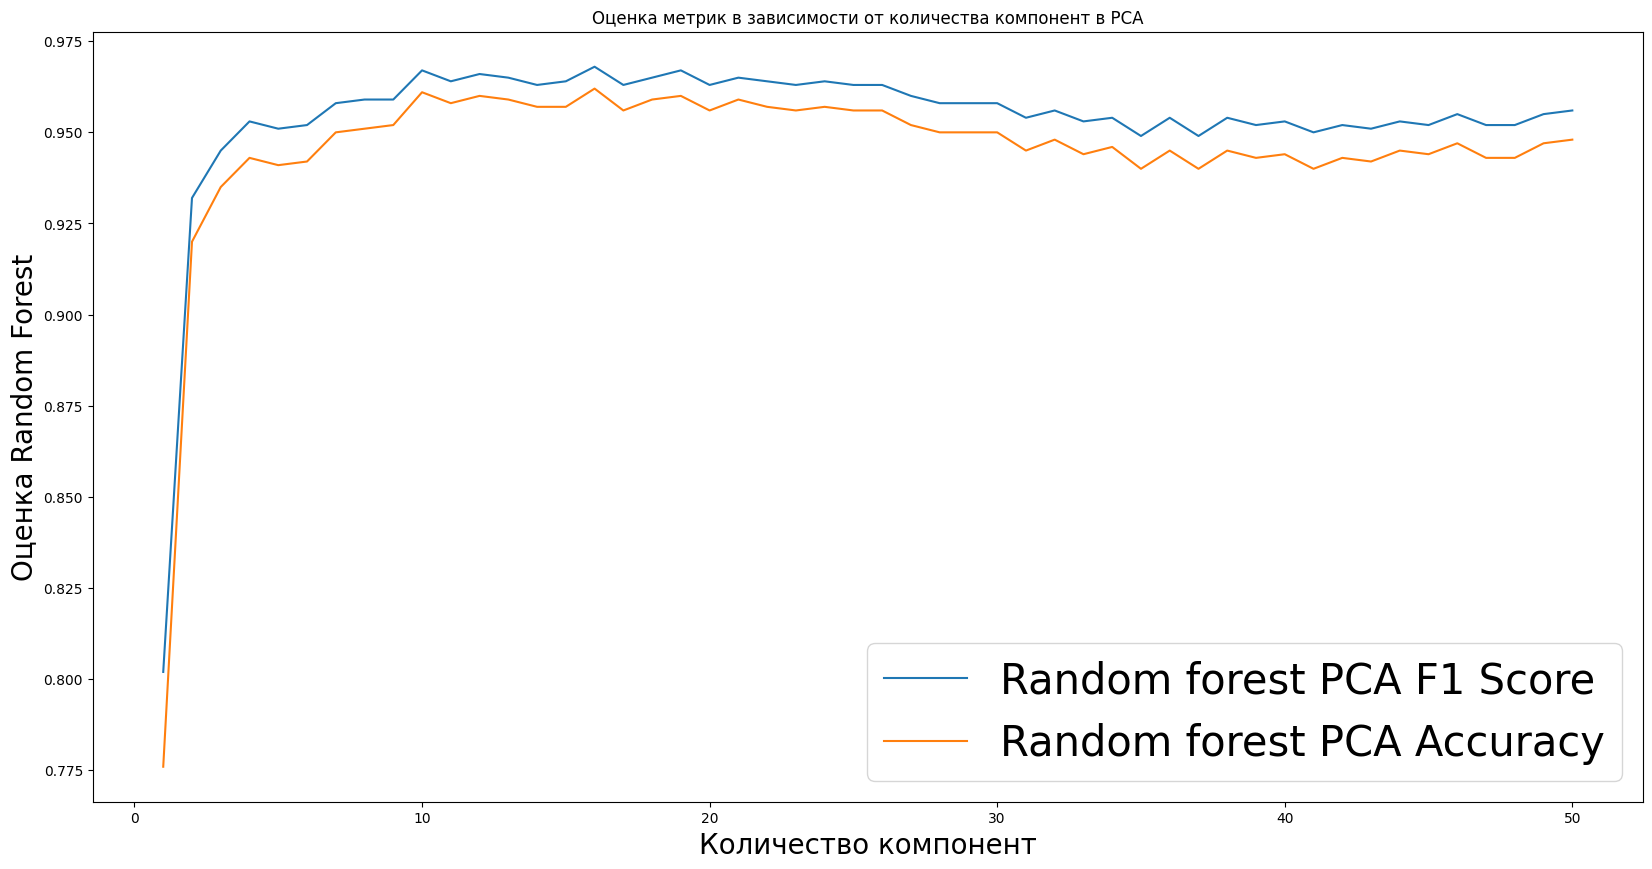

In [382]:
plt.figure(figsize=(20, 10))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество компонент", fontsize=20)

plt.title('Оценка метрик в зависимости от количества компонент в PCA')

plt.plot(pca_1_to_50.index, pca_1_to_50['Random forest PCA F1 Score'], label='Random forest PCA F1 Score')
plt.plot(pca_1_to_50.index, pca_1_to_50['Random forest PCA Accuracy'], label='Random forest PCA Accuracy')

plt.legend(prop={'size': 30})

In [383]:
pca_5_to_20 = pca_from_n_to_m_components(5, 20)
pca_5_to_20

,Random forest PCA Accuracy,Random forest PCA F1 Score,Random forest PCA Specificity,Random forest PCA Sensitivity
5,0.944,0.953,0.941,0.949
6,0.94,0.95,0.943,0.935
7,0.95,0.958,0.944,0.96
8,0.95,0.958,0.944,0.959
9,0.954,0.961,0.944,0.969
10,0.959,0.965,0.944,0.983
11,0.958,0.965,0.944,0.98
12,0.96,0.966,0.944,0.984
13,0.957,0.963,0.944,0.977
14,0.957,0.963,0.944,0.975


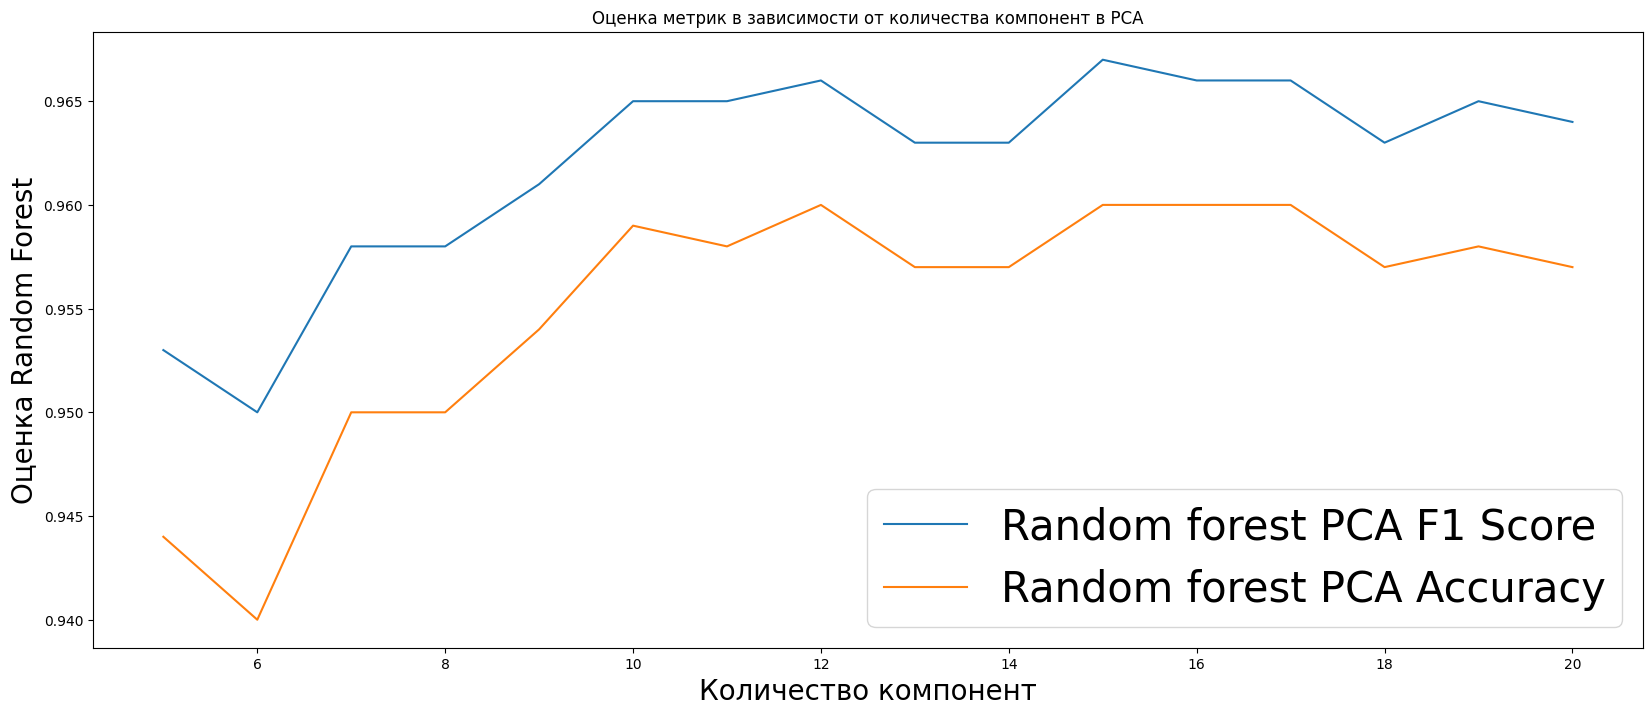

In [384]:
plt.figure(figsize=(20, 8))
#plt.xticks(rotation=30)

plt.ylabel("Oценка Random Forest", fontsize=20)
plt.xlabel("Количество компонент", fontsize=20)

plt.title('Оценка метрик в зависимости от количества компонент в PCA')

plt.plot(pca_5_to_20.index, pca_5_to_20['Random forest PCA F1 Score'], label='Random forest PCA F1 Score')
plt.plot(pca_5_to_20.index, pca_5_to_20['Random forest PCA Accuracy'], label='Random forest PCA Accuracy')

plt.legend(prop={'size': 30})

In [385]:
pca_5_to_20 = pca_5_to_20.T

In [386]:
res_all['PCA_8'] = list(pca_5_to_20[8])
res_all['PCA_13'] = list(pca_5_to_20[13])

res_all = res_all.round(3)
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,K_means_2,K_means_3,RF_best_7,RF_best_10,RF_EFS_1_6,RF_EFS_2_9,RFE,RFI,PCA_8,PCA_13
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907,0.928,0.928,0.928,0.912,0.917,0.893,0.927,0.907,0.898,0.950,0.957
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918,0.938,0.938,0.938,0.926,0.930,0.908,0.938,0.921,0.912,0.958,0.963
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863,0.942,0.943,0.945,0.903,0.911,0.879,0.919,0.895,0.879,0.944,0.944
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975,0.909,0.908,0.903,0.926,0.926,0.914,0.938,0.926,0.926,0.959,0.977


In [387]:
res_RF_PCA = res_all.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_3', 'ENS_4',	'ENS_5',	'K_means_1',	'K_means_2',	'K_means_3', 'RF_best_7', 'RF_best_10', 'RF_EFS_1_6', 'RF_EFS_2_9', 'RFE', 'RFI'])
res_RF_PCA

,RF,PCA_8,PCA_13
Точность,0.917,0.950,0.957
F1 мера,0.931,0.958,0.963
Доля верно обнаруженных больных,0.919,0.944,0.944
Доля верно обнаруженных здоровых,0.914,0.959,0.977


In [388]:
res_RF_PCA.to_csv('results/result_RF_PCA.csv')

## 5.6. Объединим EFS, RFI и PCA

In [389]:
_data = df.drop(['target'], axis=1)

PCA_output = PCA(n_components=13)
PCA_output.fit(_data)
sklearn_transformed_data = PCA_output.transform(_data)
_PCA = pd.DataFrame(sklearn_transformed_data)
_PCA

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.766081e+07,420033.647486,586879.619326,108172.923606,-2864.280979,20603.474150,-18900.866837,3245.186033,-4713.626436,-10401.929290,26916.620211,22577.277556,19506.956309
1,-8.605752e+05,-34566.704385,-15620.447572,-492.110783,-5063.741179,2917.459977,-2655.959187,-1375.443353,-534.981433,-277.040859,3060.798554,1971.309659,867.250103
2,-6.429806e+05,133933.474893,-2165.272228,3317.402367,-1471.773186,1209.023528,-1062.801098,-253.369975,-30.841648,1906.149393,741.024843,-386.526924,120.855494
3,-7.862992e+05,79569.495757,-13951.518693,-3354.307939,-2071.691367,624.750701,-361.964703,-695.171244,192.073804,1031.242397,103.413539,-865.207321,-757.877058
4,9.923238e+06,-110514.359677,30.772681,-18275.177326,4605.277203,-4181.049181,8742.374558,-1540.317756,708.102544,-11999.917374,-7681.961189,-1201.964268,-4314.259610
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,-5.751925e+05,-98758.662750,442.984842,51719.692879,-22688.276456,14987.848797,-8300.561841,-2877.985236,-3418.066521,-5621.433232,4974.711230,-4806.509651,-5710.297927
1018,-5.754527e+05,-98671.440477,540.103820,51690.929583,-22799.008067,15031.996430,-8547.222916,-2769.791265,-3429.804022,-5470.204704,5310.700769,-4533.607608,-5564.199981
1019,-5.757118e+05,-98564.445260,640.704921,51672.159210,-22893.002658,15087.330344,-8791.701290,-2657.098446,-3430.552644,-5213.893820,5662.574890,-4291.150790,-5382.301055
1020,-5.759608e+05,-98455.140645,760.116350,51663.064032,-22961.365138,15132.696567,-9000.311876,-2536.420371,-3411.104436,-4961.868003,5982.883833,-4065.318403,-5186.418262


In [390]:
efs_9 = [2276, 2254, 2282, 2316, 2310, 3273, 2313, 2271, 2322]
rfi_9 = [2186, 2142, 3537, 2177, 2152, 2149, 3544, 2147, 2185]
features_efs_rfi = set(rfi_9 + efs_9)
features_efs_rfi

{2142,
 2147,
 2149,
 2152,
 2177,
 2185,
 2186,
 2254,
 2271,
 2276,
 2282,
 2310,
 2313,
 2316,
 2322,
 3273,
 3537,
 3544}

In [391]:
df_t = df.T
df_ens = df_t.loc[list(features_efs_rfi)]
df_ens = df_ens.T
df_ens['target'] = df.target
df_ens

,2177,2147,2276,2149,2310,2152,2185,2186,2282,2316,3273,2254,2313,3537,2322,3544,2142,2271,target
0,563708.375000,562715.687500,561302.500000,560453.625000,568009.125000,559917.562500,562040.062500,563812.500000,564330.250000,569547.250000,618386.500000,561755.000000,568908.500000,603401.687500,568058.250000,600736.750000,560870.375000,561950.437500,0
1,15375.339844,15187.541992,15557.718750,15260.236328,15615.184570,15175.439453,15405.010742,15302.861328,15362.963867,15831.852539,17980.449219,15460.772461,15863.120117,17385.773438,15565.156250,17500.052734,15260.290039,15418.387695,0
2,31806.863281,32662.951172,30337.593750,32270.251953,30282.224609,32186.328125,32126.484375,31748.800781,30741.671875,29856.480469,20352.205078,30585.800781,30439.154297,17650.699219,29926.781250,17689.935547,32444.185547,30258.583984,0
3,24218.505859,24344.998047,23190.402344,24298.597656,23082.806641,24156.138672,24131.044922,24032.771484,23307.572266,23443.632813,16854.656250,23482.357422,23272.167969,14937.709961,23179.843750,14864.106445,24479.248047,23196.888672,0
4,303094.250000,301127.500000,308233.843750,300457.968750,314903.781250,300483.593750,302680.125000,303789.906250,309479.593750,314356.000000,371700.531250,306788.687500,314343.375000,359711.531250,314384.156250,357985.156250,300626.875000,308379.781250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,22418.267578,22543.992188,22430.601563,22589.820313,22260.986328,22451.833984,22443.265625,22356.267578,22770.496094,22315.832031,29712.716797,22600.992188,22015.281250,30257.056641,22142.505859,30515.199219,22311.207031,22600.001953,1
1018,22582.566406,22512.871094,22541.402344,22543.992188,22210.582031,22507.066406,22692.705078,22443.265625,22337.785156,22474.501953,29519.359375,22647.896484,22305.763672,30718.039063,22233.488281,30520.667969,22480.119141,22568.464844,1
1019,22564.251953,22580.873047,22521.099609,22512.871094,22188.423828,22589.820313,22476.832031,22692.705078,22431.828125,22015.281250,29581.453125,22500.722656,22260.986328,30266.238281,22188.679688,30293.595703,22372.001953,22372.314453,1
1020,22470.365234,22311.207031,22600.001953,22580.873047,22215.191406,22543.992188,22377.328125,22476.832031,22447.140625,22305.763672,29818.916016,22652.085938,22210.582031,30299.158203,22373.847656,30500.468750,22623.326172,22655.052734,1


In [392]:
df_ens = pd.concat([_PCA, df_ens], axis=1, join="inner")
df_ens

,0,1,2,3,4,5,6,7,8,9,...,2316,3273,2254,2313,3537,2322,3544,2142,2271,target
0,1.766081e+07,420033.647486,586879.619326,108172.923606,-2864.280979,20603.474150,-18900.866837,3245.186033,-4713.626436,-10401.929290,...,569547.250000,618386.500000,561755.000000,568908.500000,603401.687500,568058.250000,600736.750000,560870.375000,561950.437500,0
1,-8.605752e+05,-34566.704385,-15620.447572,-492.110783,-5063.741179,2917.459977,-2655.959187,-1375.443353,-534.981433,-277.040859,...,15831.852539,17980.449219,15460.772461,15863.120117,17385.773438,15565.156250,17500.052734,15260.290039,15418.387695,0
2,-6.429806e+05,133933.474893,-2165.272228,3317.402367,-1471.773186,1209.023528,-1062.801098,-253.369975,-30.841648,1906.149393,...,29856.480469,20352.205078,30585.800781,30439.154297,17650.699219,29926.781250,17689.935547,32444.185547,30258.583984,0
3,-7.862992e+05,79569.495757,-13951.518693,-3354.307939,-2071.691367,624.750701,-361.964703,-695.171244,192.073804,1031.242397,...,23443.632813,16854.656250,23482.357422,23272.167969,14937.709961,23179.843750,14864.106445,24479.248047,23196.888672,0
4,9.923238e+06,-110514.359677,30.772681,-18275.177326,4605.277203,-4181.049181,8742.374558,-1540.317756,708.102544,-11999.917374,...,314356.000000,371700.531250,306788.687500,314343.375000,359711.531250,314384.156250,357985.156250,300626.875000,308379.781250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,-5.751925e+05,-98758.662750,442.984842,51719.692879,-22688.276456,14987.848797,-8300.561841,-2877.985236,-3418.066521,-5621.433232,...,22315.832031,29712.716797,22600.992188,22015.281250,30257.056641,22142.505859,30515.199219,22311.207031,22600.001953,1
1018,-5.754527e+05,-98671.440477,540.103820,51690.929583,-22799.008067,15031.996430,-8547.222916,-2769.791265,-3429.804022,-5470.204704,...,22474.501953,29519.359375,22647.896484,22305.763672,30718.039063,22233.488281,30520.667969,22480.119141,22568.464844,1
1019,-5.757118e+05,-98564.445260,640.704921,51672.159210,-22893.002658,15087.330344,-8791.701290,-2657.098446,-3430.552644,-5213.893820,...,22015.281250,29581.453125,22500.722656,22260.986328,30266.238281,22188.679688,30293.595703,22372.001953,22372.314453,1
1020,-5.759608e+05,-98455.140645,760.116350,51663.064032,-22961.365138,15132.696567,-9000.311876,-2536.420371,-3411.104436,-4961.868003,...,22305.763672,29818.916016,22652.085938,22210.582031,30299.158203,22373.847656,30500.468750,22623.326172,22655.052734,1


In [393]:
X_ens = df_ens.drop(['target'], axis=1)
y_ens = df_ens['target']

X_ens_train, X_ens_test, y_ens_train, y_ens_test = train_test_split(X_ens, y_ens, test_size=0.2, random_state=42)

In [394]:
RF = RandomForestClassifier()
RF.fit(X_ens_train, y_ens_train)
y_pred_ens = RF.predict(X_ens_test)

cm_rf_ens = pd.DataFrame(confusion_matrix(y_ens_test, y_pred_ens))
sensitivity = cm_rf_ens[0][0] / (cm_rf_ens[0][0] + cm_rf_ens[1][0])
specificity = cm_rf_ens[1][1] / (cm_rf_ens[0][1] + cm_rf_ens[1][1])

RF_ENS_metric = [accuracy_score(y_ens_test, y_pred_ens), f1_score(y_ens_test, y_pred_ens), specificity, sensitivity]
RF_ENS_metric

[0.9512195121951219,
 0.9590163934426231,
 0.9435483870967742,
 0.9629629629629629]

In [395]:
res_all['EFS_RFI_PCA'] = RF_ENS_metric
res_all = res_all.round(3)
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,...,K_means_3,RF_best_7,RF_best_10,RF_EFS_1_6,RF_EFS_2_9,RFE,RFI,PCA_8,PCA_13,EFS_RFI_PCA
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907,0.928,...,0.928,0.912,0.917,0.893,0.927,0.907,0.898,0.950,0.957,0.951
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918,0.938,...,0.938,0.926,0.930,0.908,0.938,0.921,0.912,0.958,0.963,0.959
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863,0.942,...,0.945,0.903,0.911,0.879,0.919,0.895,0.879,0.944,0.944,0.944
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975,0.909,...,0.903,0.926,0.926,0.914,0.938,0.926,0.926,0.959,0.977,0.963


In [396]:
res_RF_EFS_RFI_PCA = res_all.drop(columns= ['LR', 'SVM', 'CB',	'ENS_1', 'ENS_2', 'ENS_3', 'ENS_4',	'ENS_5',	'K_means_1',	'K_means_2',	'K_means_3', 'RF_best_7', 'RF_best_10', 'RF_EFS_1_6', 'RF_EFS_2_9', 'RFE', 'RFI', 'PCA_8', 'PCA_13'])
res_RF_EFS_RFI_PCA

,RF,EFS_RFI_PCA
Точность,0.917,0.951
F1 мера,0.931,0.959
Доля верно обнаруженных больных,0.919,0.944
Доля верно обнаруженных здоровых,0.914,0.963


In [397]:
res_RF_EFS_RFI_PCA.to_csv('results/result_EFS_RFI_PCA.csv')

In [398]:
res_all.to_csv('results/all_results.csv')
res_all

,LR,SVM,RF,CB,ENS_1,ENS_2,ENS_3,ENS_4,ENS_5,K_means_1,...,K_means_3,RF_best_7,RF_best_10,RF_EFS_1_6,RF_EFS_2_9,RFE,RFI,PCA_8,PCA_13,EFS_RFI_PCA
Точность,0.902,0.907,0.917,0.927,0.907,0.922,0.932,0.927,0.907,0.928,...,0.928,0.912,0.917,0.893,0.927,0.907,0.898,0.950,0.957,0.951
F1 мера,0.917,0.921,0.931,0.938,0.926,0.937,0.942,0.938,0.918,0.938,...,0.938,0.926,0.930,0.908,0.938,0.921,0.912,0.958,0.963,0.959
Доля верно обнаруженных больных,0.895,0.895,0.919,0.911,0.960,0.952,0.919,0.911,0.863,0.942,...,0.945,0.903,0.911,0.879,0.919,0.895,0.879,0.944,0.944,0.944
Доля верно обнаруженных здоровых,0.914,0.926,0.914,0.951,0.827,0.877,0.951,0.951,0.975,0.909,...,0.903,0.926,0.926,0.914,0.938,0.926,0.926,0.959,0.977,0.963


В большинстве рассмотренных моделей метрики показывают очень хорошие результаты. Немного лучше выглядят модели, построенные на отобранных признаках, но незначительно. Такие хорошие результаты можно объяснить изначальной чистотой и точностью данных, а так же их большим количеством. Это очень важно, ведь сфера применения моделей - здравоохранение.

In [399]:
#pip freeze > requirements.txt